# Tutorial: Zero-Emission Vehicle Intelligence (ZEVi)
## Effectively Charging Electric Vehicles at Scale Without Breaking Power Systems (or the Bank!)

In [ ]:
# MIT License
#
#@title Copyright (c) 2023 CCAI Community Authors { display-mode: "form" }
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.

Author(s):
*   Shasha Lin, NextEra Mobility, sl4964@nyu.edu / shasha.lin@nexteraenergy.com
*   Tamara Monge, NextEra Mobility, tamara.monge@nexteraenergy.com
*   Jonathan Brophy, NextEra Mobility, jonathan.brophy@nexteraenergy.com
*   Jamie Hussman, NextEra Mobility, jamie.hussman@nexteraenergy.com
*   Michelle Lee, NextEra Mobility, michelle.lee@nexteraenergy.com
*   Sam Penrose, NextEra Mobility, samuel.penrose@nexteraenergy.com




# Table of Contents


*   [Overview](#overview)
*   [Glossary](#glossary)
*   [Climate Impact](#climate-impact)
*   [Target Audience](#target-audience)
*   [Background & Prerequisites](#background-and-prereqs)
*   [Software Requirements](#software-requirements)
*   [Data Description](#data-description)
*   [Methodology](#methodology)
*   [Results & Discussion](#results-and-discussion)
*   [References](#references)


<a name="software-requirements"></a>
# Software Requirements


In [ ]:
# python 3.10
!apt-get install python3.10
import sys
sys.path.pop(0)
sys.path.insert(0, '/usr/bin/python3.10')
!python --version

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
python3.10 is already the newest version (3.10.12-1~22.04.3).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.
Python 3.10.12


In [ ]:
%%capture
# REMINDER: run this at the start of the tutorial as it takes a few minutes
! pip install stable-baselines3==2.1.0
! pip install --quiet cvxpy==1.1.18
! pip install --quiet cvxopt==1.3.2
! pip install --quiet ecos==2.0.12
! pip install --quiet numpy==1.24.4
! pip install --quiet osqp==0.6.3
! pip install --quiet pandas==2.1.0
! pip install --quiet python-dateutil==2.8.2
! pip install --quiet pytz==2023.3.post1
! pip install --quiet qdldl==0.1.7.post0
! pip install --quiet scipy==1.8.0
! pip install --quiet scs==3.2.3
! pip install --quiet six==1.16.0
! pip install --quiet tzdata==2023.3
! pip install --quiet tenacity==8.2.3
! pip install --quiet plotly==5.17.0
! pip install --quiet matplotlib==3.8.1
! pip install --quiet matplotlib-inline==0.1.6


In [ ]:
import urllib
import json
import os
import math
import numpy as np
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from zoneinfo import ZoneInfo
from dataclasses import dataclass, field, InitVar
from typing import Optional, List
from datetime import datetime, timedelta
import pandas as pd
from cvxpy import Variable
import cvxpy as cp
from scipy.sparse import coo_array
from operator import add
from functools import reduce
from warnings import warn
from abc import abstractmethod, ABC
import warnings
warnings.filterwarnings("ignore")

<a name="overview"></a>
# 1. Overview

Transportation contributes to 29% of all greenhouse gas (GHG) emissions in the US, of which 58% are from light-duty vehicles and 28% from medium-to-heavy duty vehicles (MHDVs) [1].  Compared to internal combustion engine vehicles (ICEVs), zero and low emission vehicles (ZEVs), including battery electric vehicles (BEV), fuel cell electric vehicles (FCEV), and plug-in hybrid electric vehicles (PHEV), have drastically reduced life cycle GHG emission, even after considering manufacturing emission and controlling for vehicle motor power (See Figure 1, 2, and 3) [2] [3]. Transitioning the transportation sector from its reliance on ICEVs to ZEVs is an important strategy in climate change mitigation.

<a name="figure 1: GHG emission"></a>
>#### Figure 1. Life-cycle GHG emission reduction of ZEVs, as compared to ICEVs
<img alt="GHG passenger cars" height="500" src="https://drive.google.com/uc?export=view&amp;id=16mn4UDdgIpUGjRDVPLdrd33u9u-ncVxG" width="800"/>
<br>Source: [2]

<a name="figure 2: GHG emission per km"></a>
>#### Figure 2. Life-cycle GHG emission per km relative to vehicle motor power, for ZEVs and ICEVs
For vehicles with the same levels of peak motor power, ZEVs and PHEVs release less CO2 equivalent GHG per km of distance travelled than ICEVs.
<img alt="GHG passenger cars" height="600" src="https://drive.google.com/uc?export=view&amp;id=1xmexxzX6N_1CL46TKy7AQ2AQbwbAD8tQ" width="800"/><br>Source: [2]




<a name="figure 3: GHG of HDVs"></a>
> #### Figure 3. Life-cycle GHG emission of heavy-duty vehicles (HDVs), comparing ZEVs with ICEVs<br>
[3]: "Battery electric HDVs bought today (in 2023 in the EU) correspond to GHG emission savings of 63% or more over their life cycle compared to conventional ICE HDVs."
<img alt="GHG passenger cars" height="400" src="https://drive.google.com/uc?export=view&amp;id=1tYNYbmJ4CJ6g-f3r5fGmwfaeqN7HSbly" width="800"/>

One major challenge in replacing ICEVs with ZEVs at scale is the ability to charge growing numbers of ZEVs within the constraints of power systems in a cost-effective way. In this tutorial, we

1. describe the myriad challenges in charging EVs at scale and define common objectives, such as
    - meeting vehicle energy requirements within a limited charging window
    - minimizing energy bills
    - maximize on-site photovoltaic energy usage
    - minimizing total load on the electric grid
    - minimizing battery degradation at the charging site

2. discuss common constraints, such as:
    - vehicle trip energy requirements
    - charging station power limits
    - limits on vehicles’ time to charge between trips
    - hardware constraints such as vehicle charging power, battery charging / discharging limits

3. survey several different methods to formulate EV charging and energy dispatch as a mathematically solvable optimization problem, using tools such as:
    - model predictive control (MPC)
    - convex optimization
    - Markov decision process (MDP)
    - reinforcement learning (RL)

4. introduce a commercial application of model-based predictive control (MPC) algorithm, ZEVi<sup>TM</sup> (Zero Emission Vehicle intelligence), which solves optimal energy dispatch strategies for charging sessions of commercial EV fleets. We provide a synthetic dataset describing the operation of a school bus fleet during the first week of school in 2023, and apply ZEVi to optimize the fleets charging schedule and energy dispatch from on-site PV and the grid.

5. lastly, we briefly discuss other contexts in which methods originating from process control and deep learning, like MPC and RL, can be applied to solve problems related to climate change mitigation and adaptation. With the examples provided in this tutorial, we hope to inspire the audience to come up with their own creative ways to apply these methods in different fields within the climate domain.

<a name="glossary"></a>
## 1.1 Glossary
A list of abbreviations and terminalogies used in this tutorial.
<br><br>
**ZEV: Zero / low Emission Vehicles. These include:**
- BEV: Battery Electric Vehicle. The vehicle is powered by electricity only.
- PHEV: Plug-in Hybrid Electric Vehicle. The vehicle is equipped with both battery and internal combustion engine (ICE), and uses ICE when the battery is drained.
- PEV: Plug-in Electric Vehicle. the same as BEV.
- FCEV: Fuel Cell Electric Vehicle. The vehicle is powered by converting an alternative fuel, typically hydrogen, to electricity.


**ICEV**:
- Internal Combustion Engine Vehicle. These vehicles are powered through combustion of fuels such as gasoline and diesel.

**Vehicles classes based on gross vehicle weight rating, as defined by U.S. Federal Highway Administration FHWA**
- LDV: Light-Duty Vehicle (< 10k lbs), e.g. passenger car
- MHDV: Medium (10k to 26k lbs) to Heavy-Duty (> 26k lbs) Vehicles, e.g. buses and trucks
- HDV: Heavy-Duty Vehicles


**Terminology in electricity generation, distribution and storage**
- LV: Low Voltage. Below 1kV, which is typical for the part of the electric grid that connects directly to end users.
- MV: Medium Voltage. Refers to the range between 1kV and 36 kV, which is typical for the part of the electric grid that connects the LV network to the main distribution network.
- Transformer Station: The part of the electric grid that converts between different voltages, e.g. from MV to LV.
- PV: (Solar) Photovoltaics. Devices that convert sunlight into energy, e.g. solar panels.
- BESS: Battery Energy Storage System. A system to store energy that can be charged from different sources such as the grid and on-site PV, as well as discharges energy to power different uses such as an EV charger.

*Note: in this tutorial, we use the term BESS and on-site battery exchangeably, the same goes for solar and on-site PV*


**Energy sources and related technologies**
- CBG: Compressed Biogas
- CNG: Compressed Natural Gas
- LPG: Liquid Petrol Gas
- CCS: Carbon capture and storage
- H2: Hydrogen
- H2 NG: Hydrogen produced from Natural Gas

**Mathematical optimization and control theory**
- control setpoint: a variable's desired values as the output from an optimization to achieve a certain objective. In the context of energy dispatch optimization, this could be the power at which to charge a vehicle at a given time in order to minimize the fleet's operation cost, for example.

<a name="climate-impact"></a>
## 1.2 Climate Impact
ZEVs emit up to 89% less life cycle GHGs than their internal combustion engine (ICEV) counterparts [2], and their sales and adoption are growing rapidly due to factors such as consumers' environmental concerns, government incentives, and improved EV model availability and performance (Figure 4) [4].

<a name="figure 4: global EV sales"></a>
>#### Figure 4. Global EV Sales (2013-2022)
ZEV sales have grown exponentially for the past decade, reflecting their growing adoption due to factors such as consumers' environmental concerns,  government incentives, and increasing availability.
<img alt="EV sale percentages" height="600" src="https://drive.google.com/uc?export=view&id=1TQ7BWaDlWeYqkXKQuD1jnUTPzfLBQPrf" width="800"/>
<br>Source: [5]

Supporting increasing numbers of ZEVs on the road is an important step in de-carbonizing transportation, which not only requires building new infrastructure such as public and private charging stations, but additional optimizations on how ZEVs are charged. As shown in Figure 5, powering road vehicles that are 100% ZEVs without charging optimization may place more load than the limits of the grid allow. Optimizing ZEV charging is therefore often a necessity in the transition to zero emission transportation, and a topic of interest to many stakeholders such as utility companies, commercial fleet operators, and individual consumers.

<a name="figure 5: grid load requirements for ZEVs"></a>
>#### Figure 5. ZEV charging load on the electric grid in a scenario where 100% road vehicles are ZEVs
<br>a.<img alt="Electricity Grid Diagram" height="300" src="https://drive.google.com/uc?export=view&id=1WiXrwJ8M0NEpv8BmV3jiF82RLqbJFCk9" width="425"/>&nbsp;&nbsp;b.<img alt="Transformer overloaded by ZEV energy requirements" height="300" width="425" src="https://drive.google.com/uc?export=view&id=17rmifIoAuvKwMMZDTceij-SyUlUWNYRU"/>
<br>a: A diagram of the main components making up the electric grid, including high voltage (HV) transmission network coming out of power plants, and medium and low voltage (MV-LV) distrbution network connecting to end users (Source: [8]). Transmission and distribution substations use transformers to convert between voltages.
<br><br>b: A case study on a low voltage network in the center of a metropolitan area shows that plug-in vehicle (PEV) charging place a high load on the low-voltage distribution network, and can easily overload transformers in the network in a 100% electric mobility scenario when ZEVs' charging schedules are not optimized (Source: [9]).



As part of the tutorial, we provide a hands-on exercise solving optimal energy dispatch strategies for a ZEV fleet. We demonstrate how mathematical optimization and machine learning can be applied to reduce barriers to large-scale ZEV adoption. We hope to inspire creative solutions and effective implementations both in solving the problem of ZEV charging itself, and in solving many other climate issues that can be modeled as similar control processes, such as energy conservation in wastewater treatment [6] and automated climate policy discovery [7].

<a name="target-audience"></a>
## 1.3 Target Audience
With this tutorial, we hope to reach a wide target audience, including:
- Machine learning (ML) / AI researchers in academia and industry who are interested in learning about the energy and transportation sector, and ways ML methods could be applied to improve energy efficiency and de-carbonize transportation;
- Climate scientists and enthusiasts who are interested in adding mathematical optimization to their toolkit for solving practical challenges in the adopting of climate solutions, such as the feasibility of large-scale adoption of zero emission vehicles.

<a name="background-and-prereqs"></a>
## 1.4 Background & Prerequisites
To successfully complete the exercise in this tutorial, we recommend having some prior experience with mathematical optimization. However, you do not need prior experience with the specific algorithms (MPC and RL) introduced in this tutorial, nor do we assume any prior knowledge of energy systems or the transportation sector.


<a name="dataset introduction"></a>
# 3. Introducing a ZEV charging Dataset

## 2.1 Data Download

In [ ]:
def download_from_gdrive(file_id: str, file_path: str):
    url = f"https://drive.google.com/uc?export=download&id={file_id}"
    if not os.path.exists(file_path):
        try:
            urllib.request.urlretrieve(url, file_path)
            print(f"Successfully downloaded file to {file_path}")
        except Exception as e:
            raise e
    else:
        print(f"{file_path} already exists, no file downloaded")

In [ ]:
FILE_ID = "1bQDe6T27Q2LVaa2ZztwpKPBngmO-fn2g"
FILE_NAME = "school_bus_dataset.json"
download_from_gdrive(FILE_ID, FILE_NAME)
with open(FILE_NAME, "r") as f:
    school_bus_dataset = json.load(f)
    print(f"Data loaded as variable: school_bus_dataset")

school_bus_dataset.json already exists, no file downloaded
Data loaded as variable: school_bus_dataset


<a name="data-description"></a>
## 2.2  Data Description
The dataset simulates a fleet of 20 electric school buses operating through the first week of school in Fall 2023 (starting at 5am PT on Tuesday 9/5/2023 and finishing at 8pm PT on Friday, 9/9/2023). Each bus covers 2 routes per day, one in the morning to pick up students, and one in the afternoon to drop them off. The buses start from and return to the same charging depot before and after each trip, which is equipped with 5 industrial EV chargers, each with 5 charging ports. The charging depot also has on site solar photovoltaic (PV) panels and a battery (BESS) for energy storage. The total electricity cost is billed by the utility company operating the grid, and based on the power dispatched from the grid to the depot throughout each day.

For this exercise, we are making the following assumptions:
1. The charging depot is used exclusively by the 20 vehicles in the fleet
2. Each vehicle is always paired with the same charging port when they are at the depot: no pairing optimization is required.
3. Energy generated from on-site solar PV panels can be directly used by chargers, or stored in the on-site battery storage system (BESS) to be used by the chargers at a later time.

In [ ]:
def recursive_data_preview(data_dict: dict, printing_prefix: str = ""):
    """
    Helper function to preview fields in the dataset.
    """
    for key, value in data_dict.items():
        if isinstance(value, list):
            print(printing_prefix + f"{key} [{len(value)} record(s)]: ")
            if isinstance(value[0], dict):
                recursive_data_preview(value[0], printing_prefix=printing_prefix + "\t")
            else:
                print(printing_prefix + "\t", np.array(value)[np.array(value).nonzero()[0]][:min(len(value), 5)])
        elif isinstance(value, dict):
            print(f"{printing_prefix}{key}:")
            recursive_data_preview(value, printing_prefix=printing_prefix + "\t")
        else:
            print(printing_prefix, f"{key}: {value}")

In [ ]:
recursive_data_preview(school_bus_dataset)

scheduled_trips [160 record(s)]: 
	 vehicle_id: 1
	 distance_miles: 34.56
	 start_time: 2023-09-05 12:46:00+00:00
	 end_time: 2023-09-05 16:01:00+00:00
battery:
	 max_charge_kw: 200
	 max_discharge_kw: 200
	 charge_efficiency: 0.9
	 discharge_efficiency: 0.9
	 initial_battery_energy_kwh: 20
	 battery_capacity_kwh: 500
solar_generation_forecast_kw [348 record(s)]: 
	 [0.22  0.335 0.51  0.76  1.11 ]
chargers [5 record(s)]: 
	 charger_id: 1
	 max_power_kw: 200
	 efficiency: 0.9
vehicles [20 record(s)]: 
	 max_input_power_kw: 50
	 starting_battery_energy_kwh: 17.8
	 battery_capacity_kwh: 102
	 range_miles: 115.9
	 charging_efficiency: 0.95
	 vehicle_id: 0
	 assigned_charger_id: 1
billing_period:
	 start_time: 2023-08-25T00:00:00+00:00
	 end_time: 2023-09-26T00:00:00+00:00
electricity_rates [9 record(s)]: 
	 rate_id: 18274315
	 rate_name: California Energy Surcharge
	 charge_type: ENERGY
	 transaction_type: NET
	 rate_value_usd: 0.0003
	applicable_windows [1 record(s)]: 
		 [['00:00:00' '00

## 2.3 Data Pre-processsing and Exploration

### 2.3.1 Create python classes to represent fields in the dataset

In [ ]:
@dataclass
class ScheduledTrip:
    vehicle_id: int
    distance_miles: float
    start_time: datetime
    end_time: datetime

    def __post_init__(self):
        self.start_time = datetime.fromisoformat(self.start_time)
        self.end_time = datetime.fromisoformat(self.end_time)


@dataclass
class Battery:
    battery_capacity_kwh: float
    max_charge_kw: float
    max_discharge_kw: float
    initial_battery_energy_kwh: float
    charge_efficiency: float
    discharge_efficiency: float

    def __post_init__(self):
        assert self.initial_battery_energy_kwh <= self.battery_capacity_kwh
        assert 0 <= self.charge_efficiency <= 1
        assert 0 <= self.discharge_efficiency <= 1


@dataclass
class Charger:
    charger_id: int
    max_power_kw: float
    efficiency: float


@dataclass
class Vehicle:
    vehicle_id: int
    assigned_charger_id: int
    max_input_power_kw: float
    starting_battery_energy_kwh: float
    battery_capacity_kwh: float
    range_miles: float
    charging_efficiency: float
    scheduled_trips: List[ScheduledTrip] = field(default_factory=List[ScheduledTrip])
    reliability_buffer_kwh: float = 20
    # artificially imposed rule that we want the vehicle to always have reliability_buffer_kwh more
    # than its predicted energy need at a given time step in the forecast horizon
    estimated_energy_use_kwh: Optional[list[float]] = None


In [ ]:
@dataclass
class BillingPeriod:
    start_time: datetime
    end_time: datetime
    timesteps: np.ndarray[datetime] = field(init=False)


@dataclass
class ElectricityRate:
    rate_id: int
    rate_name: str
    charge_type: str
    transaction_type: str
    rate_value_usd: float
    applicable_windows: list[tuple] # [(start_time, end_time)]
    mask: Optional[np.ndarray[bool]] = None # whether the rate is applicable at each timestep

We update the dataset fields to use the above classes.

In [ ]:
school_bus_dataset["scheduled_trips"] = [ScheduledTrip(**trip) for trip in school_bus_dataset["scheduled_trips"]]

for vehicle_dict in school_bus_dataset["vehicles"]:
    vehicle_dict["scheduled_trips"] = list()
    for trip in school_bus_dataset["scheduled_trips"]:
        if vehicle_dict["vehicle_id"] == trip.vehicle_id:
            vehicle_dict["scheduled_trips"].append(trip)

school_bus_dataset["chargers"] = [Charger(**charger) for charger in school_bus_dataset["chargers"]]
school_bus_dataset["battery"] = Battery(**school_bus_dataset["battery"])
school_bus_dataset["vehicles"] = [Vehicle(**vehicle_dict) for vehicle_dict in school_bus_dataset["vehicles"]]
school_bus_dataset["billing_period"] = BillingPeriod(
    start_time=datetime.fromisoformat(school_bus_dataset["billing_period"]["start_time"]),
    end_time=datetime.fromisoformat(school_bus_dataset["billing_period"]["end_time"])
)

### 2.3.2 Create time steps for the simulation period
We will optimize the energy dispatch at the charging depot with 15 minute intervals:

e.g. between 9/5/2023 5:00 and 9/5/2023 5:15, we will charge vehicle 1 with 50kW power drawn from the electric grid.

To facilitate this, we create some constants representing simulation timesteps, and a helper function that rounds time stamps to its closest simulation time step:

e.g round a trip's starting time from 9:17am to 9:15am

In [ ]:
utc = ZoneInfo("UTC")
pt = ZoneInfo("US/Pacific")
SIMULATION_START_TIME = datetime(2023, 9, 5, 5, tzinfo=pt)
SIMULATION_END_TIME =  datetime(2023, 9, 8, 20, tzinfo=pt)
SIMULATION_TIMESTEP_SECONDS = 900  # we will optimize energy dispatch with a granularity of 15 minutes
SIMULATION_TIMESTEPS = list(
    map(lambda x: x.to_pydatetime(), pd.date_range(
        start=SIMULATION_START_TIME,
        periods=int((SIMULATION_END_TIME - SIMULATION_START_TIME).total_seconds() / SIMULATION_TIMESTEP_SECONDS),
        freq=str(SIMULATION_TIMESTEP_SECONDS) + "S",
    )
        )
)
FIRST_DAY_TIMESTEPS = range(int(24 * 3600 / SIMULATION_TIMESTEP_SECONDS))

print(f"simulation starts at: {SIMULATION_TIMESTEPS[0].strftime('%m/%d/%Y %H:%M')} "
      f"and ends at {SIMULATION_TIMESTEPS[-1].strftime('%m/%d/%Y %H:%M')} PT.\n")
print(f"simulation time steps are: \n"
      f"{list(map(lambda t: t.strftime('%m/%d/%Y %H:%M'), SIMULATION_TIMESTEPS[:10]))}\n"
      )

simulation starts at: 09/05/2023 05:00 and ends at 09/08/2023 19:45 PT.

simulation time steps are: 
['09/05/2023 05:00', '09/05/2023 05:15', '09/05/2023 05:30', '09/05/2023 05:45', '09/05/2023 06:00', '09/05/2023 06:15', '09/05/2023 06:30', '09/05/2023 06:45', '09/05/2023 07:00', '09/05/2023 07:15']



In [ ]:
def round_datetime(
        t: datetime,
        timesteps: List[datetime]
    ):
    """
    a helper function that rounds a time down to its closest timestep.
    will be used to pre-process electricity rates and estimate vehicles'
    energy usage for each time step
    Returns:
        idx: index of the closest timestep
        timesteps[idx]: the closest timestep
    """
    timesteps = np.array(timesteps)
    idx = np.array(
        list(map(lambda x: np.abs(x.total_seconds()), (timesteps - t)))
    ).argmin()
    if timesteps[idx] > t and idx:
        return idx - 1, timesteps[idx - 1]
    return idx, timesteps[idx]

### 2.3.3 Estimate Vehicle Energy Consumption and Visualize Vehicle Trips

We use the below utility function to estimate a vehicle's energy use for each time step with a simple heuristic:
- infer a vehicle's fuel effiency (mileage per kWh) from its battery capacity and range
- distribute a trip's mileage to each time step
- estimate the vehicle's energy consumption for each  time step based on the vehicle's fuel effiency

In [ ]:
def estimate_vehicle_energy_use(
        vehicle: Vehicle,
        simulation_timesteps: List[datetime],
        scheduled_trips: List[ScheduledTrip],
) -> np.ndarray:
    """
    computes the expected energy consumption (same length as simulation_timesteps) for a vehicle throughout the simulation
    based on the vehicle's mileage per kwh inferred from its battery capacity and range (following Eq. 17 below)
    """
    kwh_per_mile = vehicle.battery_capacity_kwh / vehicle.range_miles
    estimated_energy_use = np.zeros(len(simulation_timesteps))
    for trip in scheduled_trips:
        assert trip.vehicle_id == vehicle.vehicle_id, "scheduled_trips do not have the same vehicle_id as the vehicle"
        trip_length = (trip.end_time - trip.start_time).total_seconds()
        start_time_idx, rounded_start_time = round_datetime(trip.start_time, simulation_timesteps)
        end_time_idx, rounded_end_time = round_datetime(trip.end_time, simulation_timesteps)
        first_timestep_distance = (trip.start_time - rounded_start_time).total_seconds() / trip_length * trip.distance_miles
        last_timestep_distance = (trip.end_time - rounded_end_time).total_seconds() / trip_length * trip.distance_miles
        timestep_distance = (simulation_timesteps[1] - simulation_timesteps[0]).total_seconds() / trip_length * trip.distance_miles

        estimated_energy_use[start_time_idx] += first_timestep_distance * kwh_per_mile
        estimated_energy_use[end_time_idx] += last_timestep_distance * kwh_per_mile
        estimated_energy_use[
            list(range(start_time_idx + 1, end_time_idx))
        ] += timestep_distance * kwh_per_mile  # for all other time steps during the scheduled trip
    return estimated_energy_use

In [ ]:
for vehicle in school_bus_dataset["vehicles"]:
    vehicle.estimated_vehicle_energy_use = estimate_vehicle_energy_use(
        vehicle,
        SIMULATION_TIMESTEPS,
        vehicle.scheduled_trips,
        )

We sample 4 vehicles out of the 20 to visualize their trip schedule and estimated energy consumption per time step during the first school day.

In [ ]:
vehicles_to_visualize = np.array(school_bus_dataset["vehicles"])[range(0, len(school_bus_dataset["vehicles"]), 5)]
num_rows = len(vehicles_to_visualize)
num_cols = math.ceil(len(vehicles_to_visualize) / num_rows)
figure = make_subplots(rows=num_rows, cols=num_cols, shared_xaxes=True, shared_yaxes=True)
for i, vehicle in enumerate(vehicles_to_visualize):
    figure.add_trace(
        go.Scatter(x=np.array(SIMULATION_TIMESTEPS)[FIRST_DAY_TIMESTEPS], y=np.array(vehicle.estimated_vehicle_energy_use != 0)[FIRST_DAY_TIMESTEPS],
                   name=f"vehicle {vehicle.vehicle_id}", line_shape="hv",
                   ),
        row=i%num_rows + 1, col=math.floor(i/num_rows) + 1,
    )
figure.update_layout(title=f"Trip Schedule for {len(vehicles_to_visualize)} Sample Vehicles",
                     width=800, height=600)
figure.add_annotation(x=SIMULATION_TIMESTEPS[0] - timedelta(hours=1), y=.5,
            text="On Trip",
            showarrow=False,
            textangle=90,)
figure.show()

In [ ]:
figure = make_subplots(rows=num_rows, cols=num_cols)
for i, vehicle in enumerate(vehicles_to_visualize):
    figure.add_trace(
        go.Bar(x=np.array(SIMULATION_TIMESTEPS)[FIRST_DAY_TIMESTEPS], y=np.array(vehicle.estimated_vehicle_energy_use)[FIRST_DAY_TIMESTEPS],
                   name=f"vehicle {vehicle.vehicle_id}",
                   ),
        row=i%num_rows + 1, col=math.floor(i/num_rows) + 1,
    )
figure.update_layout(title=f"Energy Use Forecast for {len(vehicles_to_visualize)} Sample Vehicles",
                     width=800, height=600)
figure.update_yaxes(title_text="kWh")

### 2.3.4 Pre-process and visualize electricity cost

#### Time of Use Electricity Rates

It's common for the utility companies to apply several different charges, referred to as "rates", to electricity billing. For each day in a billing period, a specific rate may be applicable only for certain time windows, and its pricing may depend on the expected load level at the time (e.g. peak hours vs off-peak hours). Usually, electricity used during peak hours, when the grid expects high load from its consumers, is charged at a higher pricing than off-peak hours, when the grid expects lower load from customers.

This kind of pricing is called **time-of-use (TOU) rates**. TOU rates incentivize consumers to shift the time of their flexible charging needs to from on-peak to off-peak hours, which helps improve the grid's energy efficiency through through increased utilization of excess energy generated during off-peak hours, and reduced peak loads, which reduces the cost associated with add extra generation capacity.

Two of the most common types of TOU charges are **energy rates** and **demand rates**. For a time window in which the rate is applicable, energy rates are calculated based on the total amount (kWh) of energy consumed, whereas demand rates are calculated based on the maximum power (kW) dispatched over the billing period. The power is measured over a short time window, typically 15 minutes.



<br>*Note: TOU rates are an example of demand-side management (DSM), which is the idea of managing the demand of electricity to match its supply in order to increase the grid's effiency. We refer the audience to [14] and [15] for an overview of DSM technologies and their benefits and challenges.*

After adding the masks indicating the applicability of each energy / demand rate at a given time, we visualize the TOU rates applicable to the charging depot.

In [ ]:
def add_mask_to_electricity_rate(electricity_rate: ElectricityRate):
    """
    map the start and end time of an ElectricityRate's applicable windows
    to time steps in the simulation period, and use a boolean mask to represent
    whether a rate is active for each time step.
    """
    mask = np.array([False] * len(SIMULATION_TIMESTEPS))
    daily_windows = []
    for daily_start, daily_end in electricity_rate.applicable_windows:
        daily_start = pd.to_timedelta(daily_start)
        daily_end = pd.to_timedelta(daily_end)
        if daily_start >= daily_end:
            daily_windows.append((daily_start, timedelta(hours=24)))
        if daily_start > daily_end:  # an applicable window could be (23, 8), which means
        # from 11pm the previous day to 8am today
            daily_windows.append((timedelta(hours=0), daily_end))
        else:
            daily_windows.append((daily_start, daily_end))
    for daily_start, daily_end in daily_windows:
        dates = np.unique(list(map(lambda t: datetime(*t.timetuple()[:3], tzinfo=pt), SIMULATION_TIMESTEPS)))
        for date in dates:
            start_idx, _ = round_datetime(date + daily_start, SIMULATION_TIMESTEPS)
            end_idx, _ = round_datetime(date + daily_end, SIMULATION_TIMESTEPS)
            mask[start_idx: end_idx] = True

    electricity_rate.mask = mask.tolist()

In [ ]:
school_bus_dataset["electricity_rates"] = [ElectricityRate(**rate_dict) for rate_dict in school_bus_dataset["electricity_rates"]]
for electricity_rate in school_bus_dataset["electricity_rates"]:
        add_mask_to_electricity_rate(electricity_rate)

In [ ]:
FIRST_DAY_TIMESTEPS = range(int(24 * 3600 / SIMULATION_TIMESTEP_SECONDS))

figure = go.Figure()
for rate in  school_bus_dataset["electricity_rates"]:
    if rate.charge_type == "ENERGY":
        rate_value = np.array(rate.mask).astype(int) * rate.rate_value_usd
        figure.add_trace(
            go.Scatter(
                x=list(map(lambda t: t.astimezone(pt), np.array(SIMULATION_TIMESTEPS)[FIRST_DAY_TIMESTEPS])),
                y=rate_value[FIRST_DAY_TIMESTEPS], line_shape="hv",
                name=f"{rate.rate_name}", line_width=4, opacity=.5,),
        )
figure.update_layout(
    title="Individual Energy Rates in One Day",
    width=900, height=500,
)
figure.update_yaxes(title_text="$/kWh")
figure.show()

In [ ]:
figure = go.Figure()
for rate in  school_bus_dataset["electricity_rates"]:
    if rate.charge_type == "DEMAND":
        rate_value = np.array(rate.mask).astype(int) * rate.rate_value_usd
        figure.add_trace(
            go.Scatter(
                x=list(map(lambda t: t.astimezone(pt), np.array(SIMULATION_TIMESTEPS)[FIRST_DAY_TIMESTEPS])), y=rate_value[FIRST_DAY_TIMESTEPS], line_shape="hv",
                name=f"{rate.rate_name}", line_width=4, opacity=.5,),
        )
figure.update_layout(
    title="Individual Demand Rates in One Day",
    width=900, height=500,
)
figure.update_yaxes(title_text="$/kW")
figure.show()

As can be observed from the plots:
- energy rates and demand rates for the charging site have the same peak (noon to 6pm), mid-peak (8am to 12pm, 6pm to 11pm), and off-peak windows (11pm to 8am)rates.
- the pricing for a unit of energy consumed (energy rates) and for the maximum power dispatched (demand rates) are both the highest during peak hours and lowest during off-peak hours.
- the difference in pricing between peak and off-peak hours is especially large for demand rates, which means that dispatching large amounts of energy in a unit of time during peak hours is heavily penalized.

In the cell below, we aggregate different energy rates and demand rates respectively, to show the overall charge from the two types of rates throughout the day.

In [ ]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots


energy_rates = [rate for rate in school_bus_dataset["electricity_rates"] if rate.charge_type == "ENERGY"]
demand_rates = [rate for rate in school_bus_dataset["electricity_rates"] if rate.charge_type == "DEMAND"]
AGG_ENERGY_RATES = np.zeros((len(energy_rates), len(SIMULATION_TIMESTEPS)))
AGG_DEMAND_RATES = np.zeros((len(demand_rates), len(SIMULATION_TIMESTEPS)))
for i, energy_rate in enumerate(energy_rates):
    AGG_ENERGY_RATES[i, energy_rate.mask] = energy_rate.rate_value_usd
for i, demand_rate in enumerate(demand_rates):
    AGG_DEMAND_RATES[i, demand_rate.mask] = demand_rate.rate_value_usd
AGG_ENERGY_RATES = AGG_ENERGY_RATES.sum(axis=0)
AGG_DEMAND_RATES = AGG_DEMAND_RATES.sum(axis=0)

figure = make_subplots(2, 1, shared_xaxes=True, subplot_titles=[
    "Aggregated Energy Rate in One Day",
    "Aggregated Demand Rate in One Day"
])
figure.add_trace(
    go.Scatter(x=list(map(lambda t: t.astimezone(pt), np.array(SIMULATION_TIMESTEPS)[FIRST_DAY_TIMESTEPS])),
               y= AGG_ENERGY_RATES[FIRST_DAY_TIMESTEPS], line_shape="hv",
               name="aggregated energy rate: $/kWh", line_width=4, opacity=.8,),
    row=1, col=1,
)
figure.add_trace(
    go.Scatter(x=list(map(lambda t: t.astimezone(pt), np.array(SIMULATION_TIMESTEPS)[FIRST_DAY_TIMESTEPS])),
               y= AGG_DEMAND_RATES[FIRST_DAY_TIMESTEPS],  line_shape="hv",
               name="aggregated demand rate: $/kW", line_width=4, opacity=.8,),
    row=2, col=1,
)
figure.update_layout(width=800, height=600,
                     yaxis1=dict(title_text="$/kWh energy", range=[0, .15]),
                     yaxis2=dict(title_text="$/kW power", range=[0, 15]),
                     showlegend=False)
# color_time_of_use_periods(figure, heuristic.optimization_timestep_indices)

figure.show()


To illustrate the effect of rates tariff on energy bills, we demonstrate below how dispatching 100kWh throughout different time of the day can drastically impact total cost of operation and the load on the grid.

In [ ]:
def calculate_costs(charging_strategy: str, power:float, timestep_indices: list[int]):
    """
    calculates the energy and demand costs of uniform charging at the specified
    power for the duration of timesteps_indices and return information in dictionary
    """
    energy_cost = np.round(
        (AGG_ENERGY_RATES[timestep_indices] * power * SIMULATION_TIMESTEP_SECONDS / 3600).sum(),
        2)
    demand_cost = np.round(
        (np.unique(AGG_DEMAND_RATES[timestep_indices]) * power).sum(),
        2)
    return {"charging time": charging_strategy,
            "power": int(power),
            "energy_cost": energy_cost,
            "demand_cost": demand_cost,
            "total_cost": energy_cost + demand_cost,
            }

charging_strategy_records = []
total_energy_dispatched = 100  #kWh

# uniform charging throughout the day
power_uniform = total_energy_dispatched / 24
timestep_indices_uniform = FIRST_DAY_TIMESTEPS
charging_strategy_records.append(
    calculate_costs("charging throughout one day", power_uniform, timestep_indices_uniform)
)

# uniform charging only during peak hours
power_peak = total_energy_dispatched / 6  # peak hours of 12pm to 6pm
timestep_indices_peak = [ind for ind in FIRST_DAY_TIMESTEPS if (SIMULATION_TIMESTEPS[ind].hour >= 12) or
                                  (SIMULATION_TIMESTEPS[ind].hour < 18)]
charging_strategy_records.append(
    calculate_costs("peak  hours only", power_peak, timestep_indices_peak)
)

# uniform charging except for peak hours
power_avoiding_peak = total_energy_dispatched / (24 - 6)  # avoiding peak hours of 12pm to 6pm
timestep_indices_avoiding_peak = [ind for ind in FIRST_DAY_TIMESTEPS if (SIMULATION_TIMESTEPS[ind].hour < 12) or
                                  (SIMULATION_TIMESTEPS[ind].hour >= 6)]
charging_strategy_records.append(
    calculate_costs("off-peak and mid-peak hours", power_avoiding_peak, timestep_indices_avoiding_peak)
)

# uniform charging during off-peak hours only (avoiding mid-peak hours as well)
power_off_peak = total_energy_dispatched / 9  # off-peak hours from 0 to 8am and after 11pm
timestep_indices_off_peak = [ind for ind in FIRST_DAY_TIMESTEPS if (SIMULATION_TIMESTEPS[ind].hour < 8) or
                                  (SIMULATION_TIMESTEPS[ind].hour >= 23)]
charging_strategy_records.append(
    calculate_costs("off-peak hours only", power_off_peak, timestep_indices_off_peak)
)

KPI_df = pd.DataFrame.from_records(charging_strategy_records)

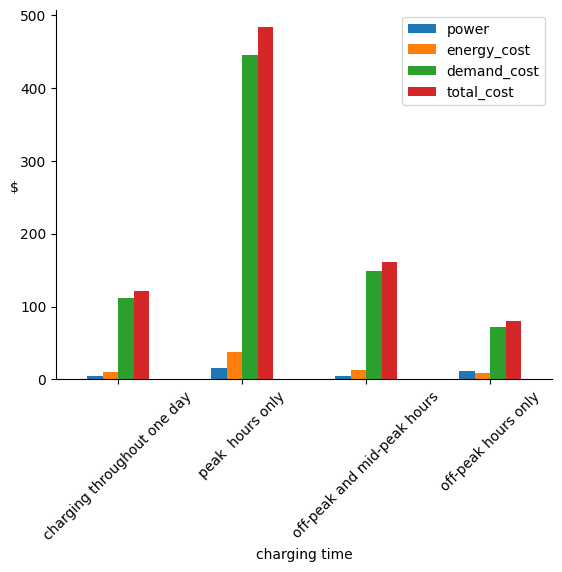

In [ ]:
import matplotlib.pyplot as plt
import matplotlib


KPI_df = KPI_df.set_index("charging time")
fig = KPI_df.plot.bar()
fig.set_xticklabels(
    KPI_df.index,
    rotation=45
)
fig.set_ylabel(
    "$", rotation=0
)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

### 2.3.5 Visualize Onsite PV Generation
The dataset includes forecasts of the onsite photovoltaic (PV, aka solar) generation at each time step throughout the simulation period.

<br>*Note: The PV energy forecasts included in this dataset is generated from a Gaussian distribution, and the topic of accurately forecasting PV energy generation is out of scope for this tutorial.*

In [ ]:
figure = go.Figure()
figure.add_trace(
    go.Scatter(
        x=np.array(SIMULATION_TIMESTEPS),
        y=np.array(school_bus_dataset["solar_generation_forecast_kw"]),
    )
)

figure.update_yaxes(title="kW")
figure.update_layout(title="On-site Photovoltaic (i.e. Solar) Generation Predictions",
                     showlegend=False, width=800, height=500,)

As seen in the plots above, each vehicle's energy consumption corresponds to the timing of the two trips: dropping off students in the morning and picking them up in the afternoon.

<a name="methodology"></a>
# 3. Methodology

Energy dispatch optimization often involves trading off multiple objectives. Some objectives we will touch on in this tutorial are:
1. meeting vehicle energy use requirements
2. minimizing electricity bill
3. maximizing use of on-site photovoltaic (PV) energy and minimizing load (i.e. total amount of energy drawn in a unit of time) on the grid
5. minimizing battery degradation associated with repeated charging and discharging

In this section we survey several different methods to formulate EV charging and energy dispatch as a mathematically solvable optimization problem. As an implementation example of solving the optimization with model predictive controll (MPC), we introduce a commercial application, **ZEVi<sup>TM</sup>** (Zero Emission Vehicle intelligence), a proprietary software platform that automates the charging of ZEV fleets to minimize operational costs for fleet operators. Some screenshots of ZEVi are shown in Figure 7.

>#### Figure 7. Screenshots of the **ZEVi**<sup>TM</sup> software platform
ZEVi uses model predictive control (MPC) to optimize ZEV fleets' charging schedule, and allows fleet managers to easily monitor schedules through a user interface. <br>
<img alt="ZEVi Screenshot: Charging Schedule" height="450" src="https://drive.google.com/uc?export=view&id=1KQPR9V8w3hQoShmH_gfXsW2ZLeafq8XB" width="1000"/>
<img alt="ZEVi Screenshot: Vehicle Schedule" height="450" src="https://drive.google.com/uc?export=view&id=13gKiizmnMxrldXbF07YeXqwX78_smzid" width="1000"/>
<br>ZEVi dashboard showing planned charging schedule and charging power for each vehicle, as well as the fluctuating electricity rates throughout the day.
<br>Source: [NextEra Mobility](https://www.nexteraenergyresources.com/nexteramobility.html)

## 3.1 Model Predictive Control

### 3.1.1 Overview
Model Predictive Control (MPC) is a popular technique for solving
optimal-control problems that have time-varying inputs. It has the below components:
1. a model of the system's behavior that describes the interaction between controllable and non-controllable input variables, and predicts the future states of the system

2. online calculation of the optimal control strategy that minimizes a cost function while respecting pre-defined constraints

3. a receding prediction horizon that shifts one timestep into the future on each new iteration of the MPC

4. system feedback that is used as initial conditions in the next iteration of the MPC


<img alt="MPC diagram" height="300" src="https://drive.google.com/uc?export=view&amp;id=1oKeZrUu-rzokb46qhXZfJCAciWMljeG8" width="450"/>

The order of operations in an MPC framework can be summarized as:
1. Ingest the state of the world, including system feedback;
2. With a model of the system, estimate its near-future states over a prediction horizon (e.g. 24 hours) under different scenarios;
3. Solve for the control setpoints (controllable variables that we are seeking to optimize) that will minimize an objective function while respecting system constraints;
4. Send the control setpoints to the system;
5. Repeat steps 1 through 4 on a specified cadence, each time moving the starting point of the prediction horizon further into the future (i.e. receding prediction horizon).




### 3.1.2 Mathematical Underpinnings of the MPC
Two components of the MPC have mathematical underpinnings: the system model and the optimization problem.

#### The System Model
The system model can be either a deterministic model derived from first principles (i.e., conservation of mass, momentum, and energy) or an empirical model obtained by fitting data. A general deterministic system model can be represented as

\begin{equation}
    x[t] = g(x[t-1], u[t-1], v[t-1]) \tag{1}
\end{equation}

where $x[t]$ represents the system's state at timestep $t$ and is a function of the system's state at the previous timestep $t-1$, $u[t-1]$ is the control setpoint at the previous timestep, $v[t-1]$ is a non-controllable process at the previous timestep, and $\mathcal{T} = \{t, \ldots, T\}$ is the set of timesteps in the prediction horizon.

#### The Optimization Problem
The optimization is often formulatd as a convex optimization problem, taking the form

\begin{align}
    \underset{x}{\text{minimize}} &\quad f_0(x) \\
    \text{subject to} &\quad f_i(x) \leq b_i, \quad i = 1, \ldots, m, \tag{2}
\end{align}

- $x$ is a vector of decision variables (i.e. control setpoints such as the power to charge a vehicle at a given time, or the power to draw from the on-site battery)
- $f_0$ is the objective function
- $f_i$ are the constraint functions
- $b_i$ are constants that represent limits in the constraints
- $f_0, ..., f_m$ are convex, meaning they satisfy the inequality

\begin{equation}
    f_i(\alpha x + \beta y) \leq \alpha f_i(x) + \beta f_i(y) \quad \forall x, y \in \mathbb{R}^n,
    \alpha, \beta \in \mathbb{R}, \tag{3}
    \text{where $\alpha + \beta = 1$, $\alpha \geq 0$, and $\beta \geq 0$ }
\end{equation}

When the objective function and constraint functions are linear, meaning they satisfy

\begin{equation}
    f_i(\alpha x + \beta y) = \alpha f_i(x) + \beta f_i(y)
    \quad \forall x, y \in \mathbb{R}^n,
    \alpha, \beta \in \mathbb{R}, \tag{4}
\end{equation}

<center><img alt="MPC diagram" height="300" src="https://drive.google.com/uc?export=view&amp;id=1NLmVGclT1Aoa7Ht9c_3OLnnnoYmr7WvG" width="450"/></center>
Figure source: [13]

we can simplify this to a linear program [13], written as

\begin{align}
    \text{minimize} &\quad c^Tx \\
    \text{subject to} &\quad a_i^Tx \leq b_i, \quad i = 1, ..., m, \tag{5}
\end{align}

where $c$ and $a_{1}$, $a_{2}$ ... $a_{m}$ are vectors of coefficients, and $b_1, ..., b_m$ are scalars.



### 3.1.3 ZEVi's MPC Implementation
In the case of ZEVi
- the **system model** comprises of:
  1. **forecasts** of the uncontrollable inputs into the optimization, which can be obtained from simple heuristics or more sophisticated forecast models. These include PV energy generation (Secion 2.4.4), vehicle energy consumption requirement (Section 2.4.5), and electricity costs (Secsion 2.4.3). Forecasts can be obtained through simple heuristics or mathematical models.
  2. **constraints** based on the energy balance of ZEVs, on-site BESS, PV generated energy, and energy drawn from the grid  at each timestep. (Eq. 5)
  3. a **composite cost function** that describes different objectives and their relative weightings, including:
      - meeting vehicle energy consumption needs
      - minimizing electricity bill in the context of a time-varying pricing curve
      - maximizing the use of on-site PV energy and minimizing load on the grid, which often has a higher carbon footprint than on-site PV
      - minimizing on-site BESS degradation from repeated charging and discharging


- The **output of the optimization** are a set of control setpoints that instruct the controllable variables in the charging station environment, so that the optimal value for the cost function is achieved. For each time step in the forecast horizon, the controllable variables include the amount of energy:
  1. each port should deliver to the vehicle it's paired with
  2. generated from on-site PV that should be directly used by chargers
  3. generated from on-site PV that should be stored into BESS
  4. drawn from the grid to dispatch energy through chargers
  6. drawn from the grid to and stored into on-site BESS
  4. discharged from BESS and dispatched through the chargers

  <br>The system diagram in Figure 8. demonstrates the direction of energy dispatch for these controllable variables.

> #### Figure 8. System diagram showing controllable variables in the charging station environment
<img alt="Diagram: Energy Dispatch Directions" height="600" src="https://drive.google.com/uc?export=view&id=15xoX3nrwT83NMGjI9tKH8zI-caIzbDoD" width="800"/>
<br>ZEVi's system model relies on an understanding of the energy balance in the environment, which are represented as constraints in the optimization.

The MPC sequence for ZEVi works as follows:
1.	A convex optimization solver takes the system's initial state (vehicle and BESS state of charge, electricity price, PV energy, and vehicle energy consumption forecasts) as input and numerically solves for the optimal control setpoints for each timestep in the forecast horizon ($x$ in Eq. 4 and 5), which minimizes the composite cost function;
2.	Charging setpoint are sent to charger ports and charging begins based on these instructions
4.	System feedback (e.g., vehicle battery's state-of-charge) is collected at next timestep
5.	Using the system feedback, repeat 1 through 4 for the next forecast horizon

### 3.1.4 MPC: pros and cons
MPC has several advantages over other process control methods, including:
1. The objective function may be linear or non-linear [11].
2. It has the ability to handle constraints on the control inputs and outputs, preventing infeasible solutions [12].
3. It can handle multi-input/multi-output (MIMO) systems and model interactions between variables to solve for all outputs simultaneously
4. It uses a model of the system being controlled which allows it to account for future predicted states of the system.


The use of a system model categorizes MPC under the umbrella of **model-based** learning methods, which can perform well when the mechanism of the system can be realiably modelled. This may not be true in many cases:
- vehicle trip schedules can be uncertain
- solar forecasts can be inaccurate in case of unstable weather patterns
- electricity can be dynamically priced based on total load on the grid, with much more granular time units (e.g. prices that are subject to change every 5 minutes)
- ...

Additionally, the convexity often assumed by MPC may not hold in practice.
>Figure 9. Non-Convexity
<br><img alt="Non-convexity" height="300" src="https://drive.google.com/uc?export=view&amp;id=17uwy22evZatf-_eBWG15VORld7A-uD2i" width="450"/>
<img alt="convex-vs-nonconvex" height="300" src="https://drive.google.com/uc?export=view&amp;id=15_UD9Xv_0uGjXSHxrmBY60-nsHyzcF9N" width="600"/>
<br>Source: [28]

When the system's behaviors substantially deviate from the model used by MPC, solutions output from the MPC may be sub-optimal. MPC partially mitigates this uncertainty by repeatedly ingesting new information on the system state and running new iterations of the optimization, which can be computationally expensive.

In the next section, we introduce **model-free** reinforcement learning methods, which removes the need of a complete model of the system.

## 3.2 Model-free Reinforcement Learning (RL)

**Reinforcement learning (RL)** is a field rooted in optimal control and the psychology of animal learning. It describes a set of problems and solutions centered on learning the optimal actions from interactions with the environment. A reinforcement learning problem is comprised of:
- an agent
- an environment
- a set of states and actions
- a policy that determines actions (or probability of actions) based on states
- rewards for the agent from each action.

<br>
<img alt="Cat" align="right" height="350" src="https://drive.google.com/uc?export=view&id=1OEz41raXa3COyl89iphG1j8eKFlvJu26" width="300" />

An example of reinforcement learning is a cat learning not to eat a poisnous house plant. In this example, the cat is an agent living in an environment: a household with a plant that is mildly poisonous to cats. The cat has two possible actions: eating the plant, and not eating it; and two states: vomitting, or not. From a few unfortunate occassions where the cat's dinner time is delayed due to its owner's busy schedule, it learns the consequences of its actions: eating the plant leads to nausea and vomiting, which serves as a negative reward, and not eating the plant prevents the nausea, a positive reward. The cat eventually forms an optimal, deterministic policy as a result of its learning: never eat the poinous plant.





### 3.2.1 Markov Decision Process
Instead of a complete system model, RL methods often conceptualize the environment as a Markov Decision Process (MDP). In an MDP, we do not attempt to build a complete system model as the MPC does, and assume the mechanisms of the environment as unknown (i.e. the absence of a system model), except for the dynamics specified by
$$p(s_{t + 1}, r_{t + 1} | s_{t}, a_{t})$$
which is the probability of transitioning into state $s_{t + 1}$ and getting reward $r_{t}$ after taking action $a_{t}$ at the current state $s_{t}$ .

In this notation,
- $s_{t}$ is the state at time step t ($s_{t} \in S$, the set of all possible states)
- $a_{t}$ is the action taken at time step t ( $a_{t} \in A$, the set of all possible actions)
- $r_{t + 1}$ is the reward obtained from taking action $a_{t}$ from state $s_{t}$ ( $r_{t + 1} \in R$, the set of all possible rewards)
- $t$ is the current time step ($t\in \{1, ... T - 1\}$, the time steps in the forecast horizon)

$p(s_{t + 1}, r_{t + 1} | s_{t}, a_{t})$ is assumed to satisfy the **Markov property**:

    The future is independent of the past conditioned on the present.

  which is to say $$p(s_{t + 1}, r_{t + 1} | s_{t}, a_{t}, s_{t - 1}, a_{t - 1}) = p(s_{t + 1}, r_{t} | s_{t}, a_{t}), ∀ t\in \{1, ... T - 1\} \tag{6}$$ Once we know the current state and the current action to take, the probability of the reward and the state in the next time step is independent of states and actions from previous time steps.  


The goal of RL is to find an **optimal policy**, which we define below. A policy $\pi(a|s)$ is a mapping between each state $s$  and the probability of every possible action $a \in A$ . Under a  policy $\pi$, the **state-value function $v$** of a state $s$ is the expected return from the entire time horizon by starting at $s$ and following policy $\pi(a|s)$ thereafter, defined as
$$v_{\pi}(s_{t}) ≐  \mathbb{E}_{\pi}\left[\sum_{k=0}^{T - t}\gamma^{k}r_{t + k + 1} | s_{t}\right]\tag{7}$$ $\gamma$ is a discount factor ($0 < \gamma < 1$): rewards obtained in future time steps are given less weight when calculating the expected rewards at a given state $s$.

Similarly, under policy $\pi$, the **action-value function, $q$** of a {state, action} pair is the expected return from the entire time horizon by starting at state $s_{t}$, taking action $a_{t}$, and following $\pi$ thereafter, defined as
$$q_{\pi}(s_{t}, a_{t}) ≐  \mathbb{E}_{\pi}\left[\sum_{k=0}^{T - t}\gamma^{k}r_{t + k + 1} | s_{t}, a_{t}\right]\tag{8}$$


An **optimal policy $\pi_{*}(a|s)$** is a policy that has the highest value $v_{\pi}(s)$ for all states $s \in S$:
$$v_{\pi_{*}}(s)≐ \max_{\pi}v_{\pi}(s), ∀ s \in S\tag{9}$$
An optimal policy also has the highest (i.e.optimal) value $q_{\pi}(s, a)$ for all states $s \in S$ and all $a \in A$: $$q_{\pi_{*}}(s, a)≐ \max_{\pi}q_{\pi}(s, a), ∀ s \in S, a \in A\tag{10}$$



[16]

#### ZEV Charging as an MDP
We can formulate the ZEV charging problem as an MDP by defining:
- ZEVs' and BESS's state of charge as the state space $S$
- control setpoints (described in the MPC section) as the action space $A$
- the negative of the objective function comprising of composite costs (described in the MPC section) as rewards $R$

For every time step in the forecast horizon $\{1, ... T - 1\}$, the optimal policy $\pi_{*}(a|s)$, i.e. the mapping between states and actions we are trying to find, has the maximum expected rewards (or equivalently, the minimum expected composite costs), for all possible states and all possible {state, action} pairs. The optimal policy $\pi_{*}(a|s)$ can be deterministic or stochastic. For a given state $s$, say vehicle 1 is at the charging station with 10% charge (we omit the state of charge for other ZEVs and BESS for the purpose of this example):
- a deterministic policy always chooses the same action: e.g. charge the vehicle with 10kW power
- a stochastic policy chooses actions based on a learned probability density: e.g. charge the vehicle with 10kW power with 40% probability, charge with 15kW with 10% probability, etc...

Note that when the number of ZEVs in the optimization are constant, we can think of the forecast horizon as infinite, i.e. $T = \infty$, in which case the MDP is called a *continuous* (v.s. episodic) MDP.

>#### Figure 10. An Example How Charging A Single ZEV Can be Formulated as an MDP
<img alt="gradient descent" height="500" src="https://drive.google.com/uc?export=view&id=189HUfEiL8aGvmHQzyWQxIO1WKk2RVZ_8" width="500"/>
<br> Orange circles represent states (e.g. the vehicle's State of Charge (SoC) and green circles represent actions (e.g. Charge 45 kWh). At each state $s_t$, a policy assigns different probabilities for each action $a_t$, which has different transition probabilities into the next step $s_{t+1}$.

### 3.2.2 Model-free RL Algorithms
There are many different approaches to the problem of finding optimal policies, hence different types of RL algorithms. Some important categorizations are *on-policy v.s. off-policy*, and *action-value methods v.s. policy gradient methods*.
#### **on-policy v.s. off-policy RL**
The on-policy and off-policy distinction is based on whether the training data is always generated from the target policy, which is the policy we are trying to optimize.
- In on-policy learning, every action used to update the target policy is generated by the same policy, which means new data points are needed for each update.
- In off-policy learning, a separate "behavior policy" is used to generate actions, allowing data points to be reused to inform target policy updates. Note that the behavior policy could be an earlier version of the target policy, as we will see in soft actor-critic algorithm described in the next section. Off-policy RL methods' ability to reuse data points affords them higher data effiency, and tend to be more feasible for complex optimization problems such as EV charging.

#### **action-value methods v.s. policy gradient methods**
RL methods can also be categorized based on the function they directly optimize:
- Policy-gradient methods such as deep deterministic policy gradient (DDPG)[18] parameterize the policy $\pi$ with a set of parameters $\phi$, and learns the optimal parameters for the policy, $\phi{*}$, through iterative updates in the direction of the gradient $\nabla J(\phi)$ of a scalar performance measure $J(\phi)$. A common performance measure is the total expected rewards from all time steps in the forecast time horizon.
$$J(\phi) = \sum_{t=0}^{T}\mathbb{E}_{(s_{t}, a_{t})\sim \pi}\left[r(s_{t}, a_{t})\right]\tag{11}$$
>#### Figure 11. (Policy) Gradient Descent
<img alt="gradient descent" height="350" src="https://drive.google.com/uc?export=view&id=16KKsXZuJYTS2ysW1jUnG5Z17r-i_O-Rq" width="350"/>
<br>Similar to other gradient descent based methods, policy gradient descent methods finds the gradient (direction of the steepest descent towards the optimal performance value) and iteratively updates its parameters in that direction.

- Action-value methods such as deep Q-learning (DQN) [17] does not learn the policy directly, but parameterizes and learns the action-value function $q_{\pi}(s, a)$ (also referred to as Q-function) instead. Actions are then selected based on their action-value.


### 3.2.3 An Example RL Algorithm: Soft Actor Critic (SAC)
#### **Actor-Critic Algorithms**
A popular class of RL algorithm is **actor-critic**. With this type of algorithm, the policy gradient and action-value function (Q-function) are both optimized together. The **actor** part of the algorithm is responsible for iteratively updating and improving the policy $\pi_{\phi}$ (this is referred to as **policy improvement**), whereas the **critic** part of the algorithm is responsible for learning a parameterized Q-function $q_{\theta}(s, a)$ ($\theta$ is the parameters), which is used to evaluate the policy (this is referred to as **policy evaluation**). Jointly optimizing $\pi_{\phi}$ and $q_{\theta}$ introduces bias but reduces the variance in $\pi_{\phi}$'s gradient estimates $\hat\nabla J(\phi)$, making the optimization more data efficient.

#### **Soft Actor Critic Algorithm**
We describe the soft actor-critic (SAC) algorithm [19] as an example of an actor-critic algorithm. In addition to the actor-critic structure, SAC has two distinguishing features:
- off-policy learning
- entropy maximization.

The pseudo-code for SAC is shown in Figure 12.

> #### Figure 12.Pseudo code for the SAC algorithm
<img alt="SAC Algorithm" height="350" src="https://drive.google.com/uc?export=view&id=1dW1Uu75uDB6DCgPSwIqAihA6l6PTba1g" width="350"/>
> <br> Note: <br>1. $\bar\psi$ is an (exponentially) moving average of $\psi$, which is used to compute $\hat{∇}_{\theta}J_Q(\theta)$ and helps reduce the variance of the gradient estimator;
<br>2. in practice, two sets of Q-function parameters, $\theta_{1}$ and $\theta_{2}$ are trained separately, and the minimum Q-function value from the two is used to estimate $\hat{∇}_{\psi}J_V(\psi)$, which has been shown to reduce the positive bias of the estimate. <br>Source: [19]

The algorithm has 3 sets of parameters: $\psi$, $\theta$, and $\phi$.
- $\theta$ is the parameters for the Q-function, $q_{\theta}(s, a)$, and updated by the critic
- $\phi$ is the parameters for the policy, $\pi_{\phi}$, and updated by the actor
- $\psi$ is the set of parameters for the state-value function $V$, which is also updated by the critic. SAC's parameterization and optimization of the state-value function is not necessary in theory, but helps stablize training in practice [19].

During the optimization, an environment step alternates with gradient steps:
- in an environment step, the actor generates actions based on the policy $\pi_{\phi}$, and adds them to a replay buffer $D$, which contains information obtained from all previously taken actions, namely $\{s_t, a_t, r(s_t, a_t), s_{t+1}\}$ for all past time step t
- in a gradient step, gradients for each parameter: $\hat{∇}_{\psi}J_V(\psi)$, $\hat{∇}_{\theta}J_Q(\theta)$, and $\hat{∇}_{\phi}J_{\pi}(\phi)$, are computed from batches of samples taken from the reply buffer $D$, and used to update the corresponding parameters $\psi$, $\theta$, $\phi$. (Note that the reuse of historical data in this step is what makes SAC an off-policy algorithm.)

One major advantage of SAC over other actor-critic algorithms is having maximum entropy as part of the performance evaluation of the policy. In place of Equation 11, the performance measure is defined as the expectation of a weighted sum of the the policy's entropy, $\mathcal{H}(\pi(\cdot | s_{t}))$,  with the reward itself over the forecast horizon.

$$J_{\phi} = \sum_{t=0}^{T}\mathbb{E}_{\pi}[r(s_{t}, a_{t}) + \alpha\mathcal{H}(\pi(·|s_{t}))]\tag{12}$$

The entropy term $\mathcal{H}(\pi(\cdot | s_{t}))$ is a measure of the policy $\pi$'s uncertainty in selecting actions at state $s_{t}$. The inclusion of the entropy term as part of the performance measure is motivated by the idea of **exploitation** v.s. **exploration** during policy learning: at each state, it's important for a policy to pick actions that it knows to generate high rewards (exploitation), while it's also important to explore a wide range of actions to acquire informatin on what the policy doesn't already know. The formulation in Equation (12) incentivizes policies that balance both aspects of learning, and as a result, speeds up the convergence towards optimality. The iterative updates performed on $𝑞_𝜃(𝑠,𝑎)$ and $\pi_{\phi}$ under this performance measure are referred to as **soft policy evaluation** and **soft policy improvement**, hence the name of the algorithm: **Soft** Actor Critic. .

### 3.2.4 Comparison between MPC and RL in ZEV Charging Optimization
We list some general, high-level pros and cons for MPC and RL.
#### **MPC**
- **pros**
  <ul>
    <li>
    Can have good performance with accurate system model  
    </li>
    <li>
    Has been successfully deployed in many fields
    </li>  
  </ul>
- **cons**
  <ul>
    <li>
    Needs to be re-run frequently (multiple times an hour) to account for any uncertainties in the system
    </li>
    <li>
    Convexity assumption may not hold in practice
    </li>
  </ul>

#### **RL**
- **pros**
  <ul>
    <li>
    Responds appropriately to uncertainties in the environment, performs better than MPC when the environment is uncertain [27]
    </li>
    <li>
    Once trained, does not need to be frequently re-trained, unless the environment drastically changes
    </li>  
  </ul>
- **cons**
  <ul>
    <li>
    Less tried and tested than MPC
    </li>
    <li>
    As can be seen in our toy SAC implementation (Section 4.5), since constraints are not explicitly formulated in many RL algorithms, careful design of the reward function is required.
    </li>
  </ul>

                                     
                                                                  

# 4. Hands-on Exercise with ZEVi's MPC Implementation
We will demonstrate one implementation of ZEVi's core functionality: calculating the optimal energy dispatch strategy from the grid and on-site energy sources (e.g. PV) to each vehicle throughout the school bus fleet's operation. We use an open source python embedded language for convex optimization, [cvxpy](https://www.cvxpy.org/version/1.1/), together with an open source linear optimization solver, [GLPK](https://www.gnu.org/software/glpk/), for mathematically formulating and solving the optimal charging strategy. For this exercise, we will use ZEVi to optimize energy dispatch for the first 24 hours of the school year (09/05/2023 05:00 to 09/06/2023 05:00 PT).

### 4.1 Coding up ZEVi's input parameters, variables, and MPC Model.

First, we group all input parameters into the MPCInput class.

In [ ]:
@dataclass
class MPCInput:
    electricity_rates: InitVar[List[ElectricityRate]]
    vehicles: List[Vehicle]
    chargers: List[Charger]
    solar_generation_forecast_kw: np.ndarray[float]
    # these are provided as constants for each iteration of the optimization.
    # forecasting solar generation is out of scope for this tutorial.
    battery: Battery
    billing_period: BillingPeriod
    site_power_limit_kw: float = np.inf
    # (pre-specified and optional) maximum total power allowed for the charging station due to factors such as hardware constraints
    energy_rates: List[ElectricityRate] = field(init=False)
    demand_rates: List[ElectricityRate] = field(init=False)
    previous_max_demand: Optional[np.ndarray[float]] = None
    # the maximum demand (average power drawn from the grid in a 15-minute interval) for each demand rate from the previous iteration

    def __post_init__(self, electricity_rates):
        self.energy_rates = [rate for rate in electricity_rates if rate.charge_type == "ENERGY" and sum(rate.mask)]
        self.demand_rates = [rate for rate in electricity_rates if rate.charge_type == "DEMAND" and sum(rate.mask)]
        self.solar_generation_forecast_kw = self.solar_generation_forecast_kw.reshape(-1, 1)
        if not self.previous_max_demand:
            self.previous_max_demand = np.zeros(len(self.demand_rates))

In [ ]:
input_params = MPCInput(
    vehicles=school_bus_dataset["vehicles"],
    electricity_rates=school_bus_dataset["electricity_rates"],
    chargers=school_bus_dataset["chargers"],
    solar_generation_forecast_kw=np.array(school_bus_dataset["solar_generation_forecast_kw"]),
    battery=school_bus_dataset["battery"],
    billing_period=school_bus_dataset["billing_period"],
    site_power_limit_kw=500,
)

Then, we create `OptVars` class, with variables to be included in the linear optimization as its attributes. The variables account for all the channels of energy flow at the charging station shown in Figure 8. The optimal values of each variable at each time step in the 24-hour forecast horizon are to be solved by ZEVi using convex optimization.

In [ ]:
@dataclass(slots=True)
class OptVars:

    num_timesteps: InitVar[int]  # total number of (15 minute) time steps in the forecast horizon, which is typically 24 hours
    num_vehicles: InitVar[int]
    num_chargers: InitVar[int]
    max_demand: Variable  # shape: (number of demand rates, )

    vehicle_charging_power: Variable  = field(init=False)
    vehicle_energy: Variable  = field(init=False)
    vehicle_slack_energy: Variable = field(init=False)
    # the gap between vehicles' energy requirements (trip energy consumption + vehicle.reliability_buffer_kwh) and vehicle_energy, shape: (num_timesteps, num_vehicles)

    battery_charging_power: Variable  = field(init=False)
    # power charged into the on-site battery from the grid or solar PV

    battery_discharging_power: Variable =  field(init=False)
    # power discharged from BESS into vehicles (through chargers)
    battery_energy: Variable  = field(init=False)
    # energy stored in BESS
    total_load_kw: Variable = field(init=False)
    # total power drawn from the grid at the charging station
    solar_used_kw: Variable = field(init=False)
    # PV power used to charge vehicles.
    solar_stored_kw: Variable = field(init=False)
    # PV power charged into BESS.


    def __post_init__(self, num_timesteps, num_vehicles, num_chargers):
        self.vehicle_charging_power = Variable(
                (num_timesteps, num_vehicles),
                name="vehicle_charging_power",
                nonneg=True,
            )  # shape: (num_timesteps, num_vehicles)
        self.vehicle_energy = Variable(
                (num_timesteps, num_vehicles),
                name="vehicle_energy",  # battery energy at the END of each time step
                nonneg=True,  # shape: (num_timesteps, num_vehicles)
            )
        self.vehicle_slack_energy = Variable(
                (num_timesteps, num_vehicles),
                name="vehicle_slack_energy",
                nonneg=True,
            )
        # positive slack protects against infeasible solutions. should be zero in feasible cases
        # shape: (num_timesteps, num_vehicles)
        self.battery_charging_power = Variable((num_timesteps, 1), name="battery_charging_power", nonneg=True)
        # shape: (num_timesteps, 1)
        self.battery_discharging_power = Variable((num_timesteps, num_chargers), name="battery_discharging_power", nonneg=True) # charging vs discharging
        # shape: (num_timesteps, num_vehicles)
        self.battery_energy = Variable((num_timesteps, 1), name="battery_energy", nonneg=True)
        # battery energy at the END of each time step, shape: (num_timesteps, 1)
        self.total_load_kw = Variable((num_timesteps, 1), name="total_load_kw", nonneg=True)
        # shape: (num_timesteps, 1)
        self.solar_used_kw = Variable((num_timesteps, num_chargers), name="solar_used_kw", nonneg=True)
        # shape: (num_timesteps, num_vehicles)
        self.solar_stored_kw = Variable((num_timesteps, 1), name="solar_stored_kw", nonneg=True)
        # shape: (num_timesteps, 1)

We use a base model class as the template for charging optimization models, with helper methods that are independent of the actual optimization algorithm. The base model class will be the parent class for both the ZEVi MPC and an eager charging heuristic, which we will use as baseline for performance comparison.

In [ ]:
@dataclass(kw_only=True)
class BaseModel(ABC):
    input_params: MPCInput
    optimization_timesteps: np.ndarray[datetime]
    optimization_timestep_indices: list[int] = field(init=False)
    timestep_hours: float = field(init=False)
    opt_vars: OptVars = field(init=False)
    forecasted_vehicle_energy_consumption: np.ndarray = field(init=False)
    charger_mapping: np.ndarray = field(init=False)   # an indicator matrix of shape num_vehicles x num_chargers, representing the pairing of each vehicle to its corresponding charger.

    def __post_init__(self):
        assert len(np.unique(self.optimization_timesteps[1:] -
                 self.optimization_timesteps[:-1])) == 1  # assert equal length for each time step
        self.timestep_hours = np.unique(self.optimization_timesteps[1:] -
                 self.optimization_timesteps[:-1])[0].total_seconds() / 3600
        self.optimization_timestep_indices = self._get_applicable_timestep_indices(np.array(SIMULATION_TIMESTEPS))
        self.forecasted_vehicle_energy_consumption = self._forecasted_vehicle_energy_consumption()
        self.charger_mapping = self._get_charger_pairing_matrix()
        self.opt_vars = self._create_variables()

    @abstractmethod
    def solve(self):
        pass

    def _get_applicable_timestep_indices(self, timesteps: np.ndarray[datetime]) -> list:
        """
        gets the indices from the timesteps that are
        within the optimization time horizon (24 hours).
        """
        return [np.where(timesteps == t)[0][0] for t in self.optimization_timesteps]

    def _forecasted_vehicle_energy_consumption(self):
        return np.column_stack(
            [vehicle.estimated_vehicle_energy_use[self.optimization_timestep_indices]
             for vehicle in self.input_params.vehicles]
        )  # shape: num_timesteps x num_vehicles

    def _create_variables(self):
        return OptVars(num_vehicles=len(self.input_params.vehicles),
                                num_timesteps=len(self.optimization_timesteps),
                                num_chargers=len(self.input_params.chargers),
                                max_demand=Variable(len(self.input_params.demand_rates),
                                nonneg=True, name="max_demand")
                                )

    def _get_charger_pairing_matrix(self) -> np.ndarray:
        """
        returns an indicator matrix with shape (num_vehicles, num_chargers),
        representing the pairing of each vehicle to its corresponding charger.
        """
        charger_mapping = coo_array(
            ([1] * len(self.input_params.vehicles), # data
                (
                    [vehicle.vehicle_id for vehicle in self.input_params.vehicles],
                    # row indidces
                    [vehicle.assigned_charger_id for vehicle in self.input_params.vehicles],
                    # col indidces
                )
             )
        ).toarray()
        return charger_mapping

    def _get_demand_scaling_factor(self) -> float:
        """
        calculate demand cost using a scaled down demand rate based
        on the start time of the prediction horizon relative to the billing period.
        details in Eq. 10 in the appendix.

        with the scaling factor multiplied, higher demand rates
        are applied towards the end of the billing cycle
        than at the beginning of the billing cycle,
        so that we do not over-index demand cost at the beginning of the cycle.
        # see [10] for a detailed discussion of demand rate scaling.
        """
        remaining_days_in_billing_period = (self.input_params.billing_period.end_time - self.optimization_timesteps[0]).total_seconds() / 3600 / 24
        return 1 / remaining_days_in_billing_period

Lastly, we create the ZEViModel class which solves the optimization. The objective of the optimization comprises several components: demand cost, energy cost, cost assigned to wasted solar energy, cost assigned to battery degradation from use (charging and discharging), and cost assigned to every kWh energy that is missing from vehicle trip requirements.

#### Table 1. ZEVi objectives

|| Objective                                                                             	 | Associated Cost Representation                                                                                                                                                                    	 |
|-|-----------------------------------------------------------------------------------------|-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
|1| meeting vehicle energy use requirements                                               	 | ZEVi.objectives["slack_energy_cost"]:<br>cost assigned to every kWh energy that is missing from vehicle trip requirements                                                                         	 |
|2| minimizing load <br>(i.e. total amount of energy drawn in a unit of time) on the grid 	 | ZEVi.objectives["demand_cost"]:<br>cost incurred from demand rates based on peak power drawn from the grid during each rate's applicable time windows.                               	 |
|3| maximizing use of on-site PV energy and reducing reliance on the grid                 	 | ZEVi.objectives["discarded_solar_cost"]:<br>a dollar amount is assigned to each kWh of unused PV energy                                                                                           	 |
|4| minimizing utility bill                                                               	 | ZEVi.objectives["energy_cost"] + ZEVi.objectives["demand_cost"]:<br>cost incurred from the energy rates based on total amount of energy used during each rate's applicable time windows. 	 |
|5| minimize battery degradation from repeated charging and discharging cycles            	 | ZEVi.objectives["battery_cycling_cost"]:<br>a dollar amount is assigned to each full charge or discharge cycle, <br>and prorated for partial charge and discharge cycles.                         	 |

The constraints are add individually for each component of the fleet's charging operations. Table 2. below lists all constraints encoded in the ZEVi model.

#### Table 2. ZEVi Constraints

| Constraint Type 	                     | Description                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              	 |
|---------------------------------------|------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| ZEVi.constraints["solar"]           	 | 1. The sum of PV generated power used by the charger and stored into on-site BESS <= total power generated from the PV                                                                                                                                                                                                                                                                                                                                                                                    	 |
| ZEVi.constraints["total_load"]        | 2. Total load <= site load limit<br>3. Total load - power charged from the grid into BESS + power discharged from BESS + PV power used directly by chargers <br>== amount of power going into chargers                                                                                                                                                                                                          	                                                                                          |
| ZEVi.constraints["vehicle"]           | 4. vehicle_charging_power <= vehicle.max_input_power_kw<br>5. vehicle_energy == vehicle energy at the first time step + cumsum(vehicle_charging power * vehicle charging efficiency * time step length)<br>- cumsum(forecasted energy consumption) (*Note:cumsum stands for "cumulative sum"*)<br>6. vehicle_energy + slack_energy >= forecasted energy consumption + vehicle_reliability_buffers<br>7. vehicle cannot charge and consume power at the same time <br>5. vehicle energy at each time step <= vehicle battery capacity                                                                                     	 |
| ZEVi.constraints["charger"]     	     | 8. total amount of power that goes into chargers >= power discharged from battery + PV power used directly by chargers<br>(because chargers could also draw power from the grid)                                                                                                                                                                                                                                                                                                                         	 |
| ZEVi.constraints["demand"]            | 9. the maximum power (max demand) during each of the TOU periods within the forecast horizon <br>>= previously observed max demand from the same billing period<br>10. the maximum power during each of the TOU periods >= total load during same period                                                                                                                                                                                                                                                  	 |
| ZEVi.constraints["battery"]           | 11. battery_discharging_power <= battery.max_discharge_kw<br>12. battery_charging_power <= battery.max_charge_kw<br>13. battery_energy <= battery.battery_capacity_kwh<br>14. PV power stored into battery <= battery_charging_power (battery_charging_power includes power from PV and from the grid)<br>15. battery_energy == battery energy at the first timestep + cumsum(battery_charging_power * charging efficiency * time step length - battery_discharging_power * time step length) 	                 |

Note: All constraints should hold for every time step in the 24-hour optimization horizon.

In [ ]:
@dataclass(kw_only=True)
class ZEViModel(BaseModel):
    """
    Zero Emission Vehicle intelligence,
    an MPC model that finds the optimal strategy for charging a fleet of vehicles,
    given a combination of objectives and constraints.

    Annotation: where objectives and constraints are created, we use [a, b] to
    provide reference to tables 1 and 2 and equation numbers in the appendix.
    """
    objective: cp.Expression = field(init=False)
    demand_rate_scaling_factor: float = field(init=False)
    opt_problem: cp.Problem = field(init=False)
    constraints: dict[list[cp.constraints.constraint.Constraint]] = field(default_factory=lambda:
    dict(
            battery=[],
            vehicle=[],
            total_load=[],
            demand=[],
            charger=[],
            solar=[],
        )
    )
    objectives: dict[list[cp.Expression]] = field(default_factory=lambda:
    dict(
        battery_cycling_cost=[],
        demand_cost=[],
        energy_cost=[],
        slack_energy_cost=[],
        discarded_solar_cost=[],
    )
                                                  )
    battery_cycling_cost: float = .01
    # dollar amount assigned to a full battery cycle (charge to full or discharge to empty)
    # to model the cost of battery degradation from use
    slack_energy_cost_per_kWh: float = 10
    # dollar amount assigned to each kWh of the difference between vehicles' required energy and actual energy
    discarded_solar_cost_per_kWh: float = 1  # dollar amount assigned to each kWh of unused PV energy

    def __post_init__(self):
        super().__post_init__()
        self.demand_rate_scaling_factor = self._get_demand_scaling_factor()
        self.add_constraints()
        self.create_objective()

    def add_constraints(self):
        self._add_total_load_constraint()
        self._add_battery_constraints()
        self._add_vehicle_constraints()
        self._add_charger_constraints()
        self._add_demand_rate_constraint()
        self._add_solar_constraint()

    def create_objective(self):
        self.objectives['energy_cost'] = sum([
            cp.sum(self.opt_vars.total_load_kw[np.array(rate.mask)[self.optimization_timestep_indices]] * rate.rate_value_usd * self.timestep_hours)
            for rate in self.input_params.energy_rates
        ])  # [Table 1.4, Eq. 7]
        self.objectives['demand_cost'] = cp.matmul(self.opt_vars.max_demand,
         [rate.rate_value_usd * self.demand_rate_scaling_factor
          for rate in self.input_params.demand_rates]
          )  # [Table 1.2, Eq. 9]
        self.objectives['battery_cycling_cost'] = cp.sum(
            self.battery_cycling_cost / self.input_params.battery.battery_capacity_kwh * (self.opt_vars.battery_charging_power + self.opt_vars.battery_discharging_power) * self.timestep_hours
        )  # [Table 1.5, Eq. 11]
        self.objectives['slack_energy_cost'] = cp.sum(
            cp.multiply(self.opt_vars.vehicle_slack_energy, self._calculate_slack_energy_weights())
        )  # [Table 1.1, Eq. 12]
        self.objectives['discarded_solar_cost'] = cp.sum(
            self.input_params.solar_generation_forecast_kw[self.optimization_timestep_indices]
            - self.opt_vars.solar_stored_kw
            - cp.sum(self.opt_vars.solar_used_kw, axis=1, keepdims=True)
        )* self.timestep_hours * self.discarded_solar_cost_per_kWh  # Table 1.3
        self.objective = self.objectives['energy_cost'] + self.objectives['demand_cost'] + self.objectives['battery_cycling_cost'] + self.objectives['slack_energy_cost'] + self.objectives["discarded_solar_cost"]  # Eq. 14

    def _get_demand_scaling_factor(self) -> float:
        """
        calculate demand cost using a scaled down demand rate based on the start time of the prediction horizon relative to the billing period.
        with the scaling factor multiplied, higher demand rates are applied towards the end of the billing cycle than at the beginning of the billing cycle, so that we do not over-index demand cost at the beginning of the cycle.
        # see [10] for a detailed discussion of demand rate scaling. (Eq. 10)
        """
        remaining_days_in_billing_period = (self.input_params.billing_period.end_time - self.optimization_timesteps[0]).total_seconds() / 3600 / 24
        return 1 / remaining_days_in_billing_period

    def _calculate_slack_energy_weights(self):
        """
        heuristic for calculating the $ assigned to every kwh of slack energy,
        punishing any nonzero slack energy at any time step.
        set self.slack_energy_cost_per_kWh
        as the total of energy and demand cost for each vehicle at each time step,
        making slack energy very expensive
        relative to other types of costs. (Eq. 13).
        """
        demand_rate_for_timesteps = np.array([
            np.array(demand_rate.mask)[self.optimization_timestep_indices] * demand_rate.rate_value_usd * self.demand_rate_scaling_factor for demand_rate in self.input_params.demand_rates
        ]).sum(axis=0)
        energy_rate_for_timesteps = np.array([
            np.array(energy_rate.mask)[self.optimization_timestep_indices] * energy_rate.rate_value_usd for energy_rate in self.input_params.energy_rates
        ]).sum(axis=0)
        cost_per_kWh_per_vehicle = ((demand_rate_for_timesteps
                                     + energy_rate_for_timesteps) / len(self.input_params.vehicles)).reshape(-1, 1)
        return cost_per_kWh_per_vehicle * self.slack_energy_cost_per_kWh

    def solve(self, verbose=False):
        self.opt_problem = cp.Problem(
            cp.Minimize(self.objective), constraints=list(reduce(add, self.constraints.values()))
        )
        self.opt_problem.solve(verbose=verbose, solver="GLPK")
        self._validate_solution()

    def _validate_solution(self):
        assert self.opt_problem.status == "optimal"
        assert np.allclose(cp.multiply(cp.sum(model.opt_vars.battery_discharging_power, axis=1, keepdims=True),
                                       model.opt_vars.battery_charging_power).value,
                           np.zeros((len(model.optimization_timesteps), 1))
                           )
        for key, constraints in self.constraints.items():
            for i, constraint in enumerate(constraints):
                assert constraint.value() == True, f"{key} constraint {i} is not satisfied!"
        infeasible_vehicle_timesteps = np.where(
            (self.opt_vars.vehicle_energy + self.opt_vars.vehicle_slack_energy).value < self.forecasted_vehicle_energy_consumption
        )
        infeasible_vehicle_ids = np.unique(infeasible_vehicle_timesteps[1])
        for vehicle_id in infeasible_vehicle_ids:
            infeasible_timesteps = (infeasible_vehicle_timesteps[0][infeasible_vehicle_timesteps[1] == vehicle_id]).tolist()
            warn(f"Vehicle {vehicle.vehicle_id} will not meet forecasted energy requirement at {np.array(SIMULATION_TIMESTEPS)[np.array(self.optimization_timestep_indices)[infeasible_timesteps]]}")

    def _add_solar_constraint(self):
        self.constraints["solar"].append(
            self.opt_vars.solar_stored_kw + cp.sum(self.opt_vars.solar_used_kw, axis=1, keepdims=True)
            <= self.input_params.solar_generation_forecast_kw[self.optimization_timestep_indices]
        )  # [Table 2.1, Eq. 32]

    def _add_battery_constraints(self):
        self.constraints["battery"].append(
            cp.sum(self.opt_vars.battery_discharging_power, axis=1) <=
            self.input_params.battery.max_discharge_kw
        )  # [Table 2.11, Eq. 25]
        self.constraints["battery"].append(
            self.opt_vars.battery_charging_power <= self.input_params.battery.max_charge_kw
        )  # [Table 2.10, Eq. 24]
        self.constraints["battery"].append(
            self.opt_vars.battery_energy <= self.input_params.battery.battery_capacity_kwh
        )  # [Table 2.13, Eq. 26]
        self.constraints["battery"].append(
            self.opt_vars.solar_stored_kw <= self.opt_vars.battery_charging_power
        ) # [Table 2.14]
        energy_delta = (self.opt_vars.battery_charging_power *
                        self.input_params.battery.charge_efficiency  *
                        self.timestep_hours - cp.sum(
                            self.opt_vars.battery_discharging_power, axis=1, keepdims=True)
                        * self.timestep_hours
        )
        self.constraints["battery"].append(
            self.opt_vars.battery_energy == self.input_params.battery.initial_battery_energy_kwh
            + cp.cumsum(energy_delta)
            )  # [Table 2.15, Eq. 23]

    def _add_total_load_constraint(self):
        self.constraints["total_load"].append(
            self.opt_vars.total_load_kw
            + cp.sum(
                self.opt_vars.battery_discharging_power * self.input_params.battery.discharge_efficiency,
                axis=1, keepdims=True,
            )  # total amount of power from battery discharge
            + cp.sum(
                self.opt_vars.solar_used_kw,
                axis=1, keepdims=True,
            )  # total amount of power from solar
            - (self.opt_vars.battery_charging_power - self.opt_vars.solar_stored_kw)
            # total amount of power going from the grid to BESS
            == cp.sum(
                cp.multiply(self.opt_vars.vehicle_charging_power @ self.charger_mapping,
                1 / np.array([charger.efficiency for charger in self.input_params.chargers]).reshape(1, -1)
                            ), axis=1, keepdims=True
            )  # total amount of power that goes into chargers
        )  # [Table 2.3, Eq. 8]
        self.constraints["total_load"].append(
            self.opt_vars.total_load_kw <= self.input_params.site_power_limit_kw
        )  # [Table 2.2, Eq. 31]

    def _add_vehicle_constraints(self):
        max_vehicle_charging_power = np.tile(
            [
                vehicle.max_input_power_kw
                / vehicle.charging_efficiency
                for vehicle in self.input_params.vehicles
            ],
            (len(self.optimization_timesteps), 1),
        )
        self.constraints["vehicle"].append(
            self.opt_vars.vehicle_charging_power <= max_vehicle_charging_power
            )  # [Table 2.4, Eq. 19]
        vehicle_reliability_buffers = np.array(
            [vehicle.reliability_buffer_kwh for vehicle in self.input_params.vehicles]
        ).reshape(1, -1) # shape: 1 x num_vehicles
        starting_energy_kwh = np.array(
            [vehicle.starting_battery_energy_kwh for vehicle in self.input_params.vehicles]
            ).reshape(1, -1) # shape: 1 x num_vehicles
        vehicle_charging_efficiencies = np.array(
            [vehicle.charging_efficiency for vehicle in self.input_params.vehicles]
            ).reshape(1, -1)
        self.constraints["vehicle"].append(
            self.opt_vars.vehicle_energy == starting_energy_kwh + cp.cumsum(
            cp.multiply(self.opt_vars.vehicle_charging_power,
                        vehicle_charging_efficiencies) * self.timestep_hours)
             - cp.cumsum(self.forecasted_vehicle_energy_consumption)
             )  # [Table 2.5, Eq. 16]
        self.constraints["vehicle"].append(
            self.opt_vars.vehicle_energy + self.opt_vars.vehicle_slack_energy
            >= self.forecasted_vehicle_energy_consumption + vehicle_reliability_buffers
        )  # [Table 2.6]
        self.constraints["vehicle"].append(
            cp.multiply(
                self.opt_vars.vehicle_charging_power,
                self.forecasted_vehicle_energy_consumption,
            ) == np.zeros(self.forecasted_vehicle_energy_consumption.shape)
        )  # [Table 2.7]

    def _add_charger_constraints(self):
        charger_max_power = np.tile(
            [
                charger.max_power_kw
                / charger.efficiency
                for charger in self.input_params.chargers
            ],
            (len(self.optimization_timesteps), 1),
        )
        self.constraints["charger"].append(
            self.opt_vars.vehicle_charging_power @ self.charger_mapping
            <=
            charger_max_power
        )
        self.constraints["charger"].append(
            cp.multiply(self.opt_vars.vehicle_charging_power @ self.charger_mapping,
                        1 / np.array([charger.efficiency for charger in self.input_params.chargers]).reshape(1, -1)
                        ) # total amount of power that goes into chargers
            >=
            (
                cp.multiply(self.opt_vars.battery_discharging_power, self.input_params.battery.discharge_efficiency)
                + self.opt_vars.solar_used_kw
            )
        )  # [Table 2.8, Eq. 21]

    def _add_demand_rate_constraint(self):
        max_demand = cp.hstack([cp.max(self.opt_vars.total_load_kw[
                    np.array(demand_rate.mask)[self.optimization_timestep_indices]
                ]) for demand_rate in self.input_params.demand_rates])
        self.constraints["demand"].append(
            self.opt_vars.max_demand >= max_demand
            )  # [Table 2.10, Eq. 29]
        self.constraints["demand"].append(
            self.opt_vars.max_demand >= self.input_params.previous_max_demand
            )  # [Table 2.9, Eq. 30]


## 4.2 Run ZEVi for the first 24 hours of operation

In [ ]:
model = ZEViModel(
    input_params=input_params,
    optimization_timesteps=np.array(SIMULATION_TIMESTEPS[: int(3600 * 24 / 900)]),
    battery_cycling_cost=.01,
    discarded_solar_cost_per_kWh=.1,
    slack_energy_cost_per_kWh=20
)
model.solve(verbose=True)

                                     CVXPY                                     
                                    v1.1.18                                    
(CVXPY) Apr 16 07:04:42 PM: Your problem has 7109 variables, 16 constraints, and 0 parameters.
(CVXPY) Apr 16 07:04:42 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Apr 16 07:04:42 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Apr 16 07:04:42 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Apr 16 07:04:42 PM: Compiling problem (target solver=GLPK).
(CVXPY) Apr 16 07:04:42 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing

In [ ]:
print(f"energy cost from ZEVi optimization: {model.objectives['energy_cost'].value:.2f}")
print(f"demand cost from ZEVi optimization: {model.objectives['demand_cost'].value / model.demand_rate_scaling_factor:.2f}")
print(f"{model.objectives['slack_energy_cost'].value=:.2f}")

energy cost from ZEVi optimization: 60.50
demand cost from ZEVi optimization: 1547.41
model.objectives['slack_energy_cost'].value=0.00


We plot different aspects of the optimal energy usage found by the MPC below.

In [ ]:
from plotly import graph_objs as go
import plotly.express as px
from plotly.subplots import  make_subplots

def color_time_of_use_periods(fig: go.Figure, time_step_indices: list[int]):
    relevant_energy_rates = AGG_ENERGY_RATES[time_step_indices]
    time_of_use_borders = [0] + np.where(relevant_energy_rates[1:] - relevant_energy_rates[:-1])[0].tolist() + [-1]
    TOU_periods = {
        sorted(np.unique(AGG_ENERGY_RATES))[1]: {
            "name": "off-peak",
            "color": "white",
        },
        sorted(np.unique(AGG_ENERGY_RATES))[2]: {
            "name": "mid-peak",
            "color": "lightgray",
        },
        sorted(np.unique(AGG_ENERGY_RATES))[3]: {
            "name": "on-peak",
            "color": "darkgray",
        }
    }
    for idx, (i, j) in enumerate(zip(time_of_use_borders[:-1], time_of_use_borders[1:])):
        TOU_period = TOU_periods[AGG_ENERGY_RATES[time_step_indices[j]]]
        fig = fig.add_vrect(x0=np.array(SIMULATION_TIMESTEPS)[time_step_indices[i]],
                      x1=np.array(SIMULATION_TIMESTEPS)[time_step_indices[j]], line_width=0, fillcolor=TOU_period["color"], opacity=0.2, annotation_text=TOU_period["name"])
    return fig

def plot_optimal_powers(models_to_visualize: list[ZEViModel],
                        model_names: list[str],
                        datetime_range: tuple[datetime],
                        title="Energy Usage During First School Day"):
    colors = px.colors.qualitative.Plotly
    figure = make_subplots(1,
                           len(models_to_visualize),
                           shared_xaxes=True, shared_yaxes=True,
                           # specs=[[{"secondary_y": True}, {"secondary_y": True}]],
                           subplot_titles=model_names, horizontal_spacing=.05)
    for i, model in enumerate(models_to_visualize):
        lines_to_plot = [
            {
                "y": model.input_params.solar_generation_forecast_kw.flatten()[model.optimization_timestep_indices],
                "name": "on-site solar generation",
            },
            {
                "y": cp.sum(model.opt_vars.solar_used_kw, axis=1, keepdims=False).value,
                "name": "solar used",
            },
            {
                "y": model.opt_vars.solar_stored_kw.value.flatten(),
                "name": "solar stored",
            },
            {
                "y": model.opt_vars.battery_charging_power.value.flatten(),
                "name": "battery charging power",
            },
             {
                "y": model.opt_vars.battery_discharging_power.value.sum(axis=1),
                "name": "battery discharging power",
            },
            {
                "y": model.opt_vars.vehicle_charging_power.value.sum(axis=1),
                "name": "power charged to vehicles",
            },
            {
                "y": cp.sum(model.forecasted_vehicle_energy_consumption, axis=1).value,
                "name": "power consumed by vehicles",
            },
            {
                "y": model.opt_vars.total_load_kw.value.flatten(),
                "name": "power drawn from grid (total_load)",
            },
        ]
        for j, line in enumerate(lines_to_plot):
            figure.add_trace(
                go.Scatter(
                    x=model.optimization_timesteps,
                    y=line["y"],
                    name=line["name"], line=dict(width=3, color=colors[j]), showlegend=(i==0),
                ), secondary_y=line.get("secondary_y", False),
                row=1, col=i  + 1,
            )
    figure = color_time_of_use_periods(figure, list(range(
        np.where(np.array(SIMULATION_TIMESTEPS) == datetime_range[0])[0][0],
        np.where(np.array(SIMULATION_TIMESTEPS) == datetime_range[1])[0][0],
    )))
    figure.update_layout(title=title,
                         width=1000,
                         height=500,
                         legend=dict(yanchor="top", y=0.9, xanchor="left", x=0.7)
                         )
    figure.update_yaxes(title_text="kW", secondary_y=False)
    figure.update_xaxes(range=datetime_range)
    figure.show()
    return figure

In [ ]:
fig = plot_optimal_powers([model], datetime_range=(SIMULATION_TIMESTEPS[0], datetime(2023, 9, 5, 21, tzinfo=pt)), model_names=["original ZEVi run"])

A few observations:
1. Vehicle energy use (pink line)  has two peaks: one for morning pick-ups and one for evening drop-offs;
2. Little energy is drawn from the grid (light green) during on-peak hours — vehicles were mostly charged from solar and battery during these hours;
3. Solar energy was either used directly to charged vehicels or stored into battery: no amount of PV energy was wasted.

## 4.3. ZEVi v.s. Eager Heuristic
Using the same base model class as ZEVi, we create an simple optimization model that uses a heuristic to schedule ZEV charging, and compare the outputs to see how MPC performs against a simple baseline.

With the eager charging heuristic:
- we simply charge each vehicle with the maximum power allowed, until it's fully charged or the start of its next trip, whichever comes first
- We try to use PV power or power discharged from on-site BESS when possible, before drawing power from the grid
- Any excess PV energy that can be stored is stored

In [ ]:
from dataclasses import fields

# TODO fix bug in this
@dataclass(kw_only=True)
class EagerChargingHeuristic(BaseModel):
    """
    A class representing the heuristic of eager charging,
    which simply charges vehicles with maximum power
    possible until either the vehicle is fully charged,
    or the vehicle needs to start a trip.
    For each time step, try to use solar power or battery discharge
    instead of drawing from the grid, and store any excess solar power as much as possible.

    Simplifying Assumption(s):
    - charging vehicles at vehicle.max_input_power_kw does not violate
    site_power_limit_kw or charger.max_power_kw (this holds for our dataset)
    """

    energy_cost: float = 0
    demand_cost: float = 0

    def __post_init__(self):
        super().__post_init__()
        self.energy_required_per_timestep = np.zeros(len(self.optimization_timesteps))
        charger_efficiency_for_vehicles = self.charger_mapping @ np.array(
            [charger.efficiency for charger in self.input_params.chargers]
            )
        self.vehicle_charging_effiency = charger_efficiency_for_vehicles.flatten() * np.array([vehicle.charging_efficiency for vehicle in self.input_params.vehicles])
        self._init_opt_var_values()

    def _init_opt_var_values(self):
        """
        set initial values for optimization variables as zeros
        """
        for field in fields(self.opt_vars):
            if isinstance(getattr(self.opt_vars, field.name), Variable):
                opt_var_field = getattr(self.opt_vars, field.name)
                opt_var_field.value = np.zeros(getattr(self.opt_vars, field.name).shape)
                setattr(self.opt_vars, field.name, opt_var_field)


    def solve(self):
        self._get_energy_required_per_timestep()
        self._eagerly_optimize_solar_and_bess()
        self.energy_cost = sum([
            cp.sum(self.opt_vars.total_load_kw[np.array(rate.mask)[self.optimization_timestep_indices]] * rate.rate_value_usd * self.timestep_hours)
            for rate in self.input_params.energy_rates
        ]).value
        self.demand_cost = sum([
            cp.max(self.opt_vars.total_load_kw[np.array(rate.mask)[self.optimization_timestep_indices]] * rate.rate_value_usd)
            for rate in self.input_params.demand_rates
        ]).value


    def _get_energy_required_per_timestep(self):
        """
        when a vehicle is not on a trip, charge it at vehicle.max_input_power_kw
        until it reaches full charge or its next trip starts

        set self.energy_required_per_timestep as the sum of energy
        charged into all vehicles at each time step
        """
        for i, vehicle in enumerate(self.input_params.vehicles):
            previous_trip_end_idx = 0
            vehicle_energy = vehicle.starting_battery_energy_kwh
            kw_per_mile = vehicle.battery_capacity_kwh / vehicle.range_miles
            for j, trip in enumerate(sorted(vehicle.scheduled_trips, key=lambda x: x.start_time)):
                if self.optimization_timesteps[0] < trip.start_time <= self.optimization_timesteps[-1]:
                    # trips within optimization time horizon
                    trip_start_idx, _ = round_datetime(trip.start_time, SIMULATION_TIMESTEPS)
                    trip_end_idx, _ = round_datetime(trip.end_time, SIMULATION_TIMESTEPS)
                    vehicle_charging_input = np.ones(
                        trip_start_idx - previous_trip_end_idx
                        ) * vehicle.max_input_power_kw * self.timestep_hours
                    vehicle_charging_input[
                        (vehicle_energy + vehicle_charging_input.cumsum()
                        * self.vehicle_charging_effiency[i]
                         ) > vehicle.battery_capacity_kwh
                         ] = 0
                    self.energy_required_per_timestep[
                        previous_trip_end_idx: trip_start_idx
                        ] += vehicle_charging_input
                    vehicle_energy = (
                        vehicle_energy + vehicle_charging_input.sum() *
                        self.vehicle_charging_effiency[i] -
                        trip.distance_miles * kw_per_mile
                        )# update vehicle energy to the value expected at the start of the next trip
                    previous_trip_end_idx = trip_end_idx

    def _eagerly_optimize_solar_and_bess(self):
        battery_energy = self.input_params.battery.initial_battery_energy_kwh
        for i in range(len(self.optimization_timesteps)):
            opt_var_values_for_step = dict(
                solar_stored_for_step = 0,
                solar_used_for_step = 0,  # the sum from all chargers
                battery_charging_power_for_step = 0,
                battery_discharging_power_for_step = 0,
                vehicle_charging_power_for_step = self.energy_required_per_timestep[i],
                # the sum from all vehicles
            )

            energy_required_for_step = self.energy_required_per_timestep[i]
            solar_for_step = self.input_params.solar_generation_forecast_kw[i] * self.timestep_hours
            if energy_required_for_step <= solar_for_step:
                # if solar alone is sufficient for total charging needs
                self.opt_vars.total_load_kw.value[i, 0] = 0
                energy_charged_to_bess = min(
                    solar_for_step - energy_required_for_step,
                    self.input_params.battery.max_charge_kw * self.timestep_hours,
                    self.input_params.battery.battery_capacity_kwh - battery_energy
                ) # if battery isn't full, store excess solar in battery
                battery_energy += energy_charged_to_bess * self.input_params.battery.charge_efficiency
                opt_var_values_for_step["solar_stored_for_step"] = energy_charged_to_bess / self.timestep_hours
                opt_var_values_for_step["battery_charging_power_for_step"] = energy_charged_to_bess / self.timestep_hours

            elif energy_required_for_step > solar_for_step:
              # if solar alone isn't sufficient for total charging needs
                self.opt_vars.total_load_kw.value[i, 0] = energy_required_for_step - solar_for_step
                opt_var_values_for_step["solar_used_for_step"] = self.input_params.solar_generation_forecast_kw[i]
                energy_discharged_from_bess = min(
                    energy_required_for_step - solar_for_step,
                    self.input_params.battery.max_discharge_kw * self.timestep_hours,
                    battery_energy
                )
                # if drawing energy from battery is possible,
                # use battery energy first before drawing energy from the grid
                self.opt_vars.total_load_kw.value[i, 0] -= energy_discharged_from_bess * self.input_params.battery.discharge_efficiency
                battery_energy -= energy_discharged_from_bess
                opt_var_values_for_step["battery_discharging_power_for_step"] = energy_discharged_from_bess / self.timestep_hours
            self.opt_vars.battery_energy.value[i, 0] = battery_energy
            self._update_opt_var_values_for_step(opt_var_values_for_step, i)

    def _update_opt_var_values_for_step(self, opt_var_values_for_step: dict, i: int):
        step_idx = self.optimization_timestep_indices[i]
        self.opt_vars.solar_stored_kw.value[step_idx, :] = opt_var_values_for_step["solar_stored_for_step"]
        self.opt_vars.solar_used_kw.value[step_idx, :] = opt_var_values_for_step["solar_used_for_step"] / len(self.input_params.chargers)
        # equally distribute solar usage to all chargers
        self.opt_vars.battery_charging_power.value[step_idx, :] = opt_var_values_for_step["battery_charging_power_for_step"]
        self.opt_vars.battery_discharging_power.value[step_idx, :] = opt_var_values_for_step["battery_discharging_power_for_step"]
        self.opt_vars.vehicle_charging_power.value[step_idx, :] = opt_var_values_for_step["vehicle_charging_power_for_step"] / len(self.input_params.vehicles)

In [ ]:
heuristic = EagerChargingHeuristic(
    input_params=input_params,
    optimization_timesteps=np.array(SIMULATION_TIMESTEPS[: int(3600 * 24 / 900)]),
)
heuristic.solve()

In [ ]:
import plotly.graph_objs as go
import plotly.io as pio
# pio.renderers.default = 'png'


figure = go.Figure()
figure.add_trace(
    go.Scatter(
        x=heuristic.optimization_timesteps,
        y=heuristic.opt_vars.total_load_kw.value.flatten(),
        name="heuristic total load",
    )
)
figure.add_trace(
    go.Scatter(
        x=model.optimization_timesteps,
        y=model.opt_vars.total_load_kw.value.flatten(),
        name="ZEVi total load",
    )
)
figure.update_layout(
    title="load on grid: eager charging heuristic vs ZEVi"
)
figure.update_yaxes(title="kW")
color_time_of_use_periods(figure, heuristic.optimization_timestep_indices)
figure.show()

In [ ]:
plot_optimal_powers([heuristic], datetime_range=(SIMULATION_TIMESTEPS[0], datetime(2023, 9, 5, 21, tzinfo=pt)), model_names=[ "heuristic"])

In [ ]:
plot_optimal_powers([model, heuristic], datetime_range=(SIMULATION_TIMESTEPS[0], datetime(2023, 9, 5, 21, tzinfo=pt)), model_names=["ZEVi", "heuristic"])

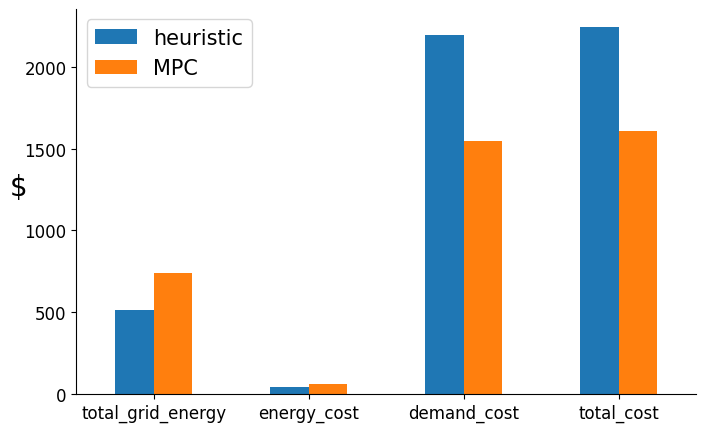

In [ ]:
# compare total energy use
heuristic_total_energy = np.round(cp.sum(heuristic.opt_vars.total_load_kw).value * heuristic.timestep_hours, 2)
model_total_energy = np.round(cp.sum(model.opt_vars.total_load_kw).value * model.timestep_hours, 2)

# compare costs
heuristic_energy_cost = np.round(heuristic.energy_cost, 2)
model_energy_cost = np.round(model.objectives['energy_cost'].value, 2)

heurisitc_demand_cost = np.round(heuristic.demand_cost, 2)
model_demand_cost = np.round(model.objectives['demand_cost'].value / model.demand_rate_scaling_factor, 2)


KPI_df = pd.DataFrame(
    {"total_grid_energy": [heuristic_total_energy, model_total_energy],
    "energy_cost": [heuristic_energy_cost, model_energy_cost],
    "demand_cost": [heurisitc_demand_cost, model_demand_cost],
     "total_cost": [
        heuristic_energy_cost + heurisitc_demand_cost,
        model_energy_cost + model_demand_cost]
     },
    index=["heuristic", "MPC"],
)
fig = KPI_df.T.plot.bar()
fig.set_xticklabels(
    KPI_df.columns,
    rotation=0
)
fig.set_ylabel(
    "$", rotation=0, size=20
)
plt.gca().tick_params(axis='both', which='major', labelsize=12)
plt.gcf().set_figheight(5)
plt.gcf().set_figwidth(8)
plt.legend(fontsize=15)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.savefig("zevi_vs_mpc")

In [ ]:
KPI_df.T

,heuristic,MPC
total_grid_energy,512.18,739.92
energy_cost,44.23,60.50
demand_cost,2196.22,1547.41
total_cost,2240.45,1607.91


Observations:
1. Compared to the ZEViModel, eager charger heuristic incurred much higher demand charge despite lowering load on the grid due to high grid usage during mid-peak hours;
2. ZEViModel made full use of solar power generated on-site by either charging EVs directly, or storing them into on-site BESS, whereas the heuristic did not;
3. ZEViModel had more BESS utilization, charging it during off-peak hours and discharging during mid-peak / on-peak hours, therefore reducing the load on the grid during these hours.
4. ZEViModel had higher energy usage overall due to charigng battery from the grid during off-peak hours, where solar generation is near zero. From the grid's perspective, this can be a worthy trade-off given the hence reduced demand during peak hours.

## 4.4 Running ZEVi with system feedback
Update forecasts to reflect deviations from expectation (e.g. trips taking longer and requiring more energy etc, solar generating less energy than expected), run MPC again and compare outputs with the first iteration.

We simulate a scenario where there are deviations from expectations in the charging site conditions, and run ZEViModel again at noon to see how it responds to these conditions.
1. There was some unexpected rain showers between 7 and 9am, reducing PV generated power from its forecasted levels
2. Weather forecast was updated for the afternoon, where more rain is expected between 3 to 5pm

To simulate the effect of raining weather on ZEV operations, we make the following adjustments:
1. For any timestep where a vehicle is driving during the rain, the energy consumption for that timestep is increased by a certain percentage due to increased drag from driving on wet roads
2. The rain also prolongs trips due to harder driving conditions.

In [ ]:
import math


def reduce_solar(
        mpc_input: MPCInput,
        start: datetime,
        end: datetime,
        reduction_ratio: float = .2,
) -> None:
    start_idx, _ = round_datetime(start, SIMULATION_TIMESTEPS)
    end_idx, _ = round_datetime(end, SIMULATION_TIMESTEPS)
    mpc_input.solar_generation_forecast_kw[start_idx: end_idx, :] = ((1 - reduction_ratio) * np.array(mpc_input.solar_generation_forecast_kw[start_idx: end_idx, :])).tolist()

def increase_trip_energy_consumption(
        vehicle: Vehicle,
        start: datetime,
        end: datetime,
        increase_ratio: float = .1,
) -> None:
    start_idx, _ = round_datetime(start, SIMULATION_TIMESTEPS)
    end_idx, _ = round_datetime(end, SIMULATION_TIMESTEPS)
    rain_mask = np.array([False] * len(SIMULATION_TIMESTEPS))
    rain_mask[start_idx: end_idx] = True
    vehicle.estimated_vehicle_energy_use[rain_mask] = vehicle.estimated_vehicle_energy_use[rain_mask] * (1 + increase_ratio)


def increase_trip_duration(
        vehicle: Vehicle,
        start: datetime,
        end: datetime,
        scheduled_trip: ScheduledTrip,
        increase_ratio: float = .15,  # e.g. if the rain covered 30 minutes of a vehicle's scheduled trip,
        # total trip duration would extend 30 * increase_ratio minutes
) -> None:

    assert scheduled_trip.vehicle_id == vehicle.vehicle_id
    if scheduled_trip.start_time >= end or scheduled_trip.end_time <= start:
        return
    start_idx, _ = round_datetime(start, SIMULATION_TIMESTEPS)
    end_idx, _ = round_datetime(end, SIMULATION_TIMESTEPS)
    rain_mask = np.array([False] * len(SIMULATION_TIMESTEPS))
    rain_mask[start_idx: end_idx] = True
    timesteps_in_rain = np.where((vehicle.estimated_vehicle_energy_use.flatten() != 0) &
    rain_mask)[0]
    scheduled_trip.end_time = scheduled_trip.end_time + timedelta(hours=len(timesteps_in_rain) * increase_ratio * model.timestep_hours)
    num_extended_timesteps = math.ceil(len(timesteps_in_rain) * increase_ratio)
    original_trip_timesteps = list(range(
                               round_datetime(trip.start_time, SIMULATION_TIMESTEPS)[0],
                               round_datetime(trip.end_time, SIMULATION_TIMESTEPS)[0] + 1
    ))
    new_trip_timesteps = original_trip_timesteps + list(
        range(original_trip_timesteps[-1] + 1, original_trip_timesteps[-1] + 1 + num_extended_timesteps)
    )
    vehicle.estimated_vehicle_energy_use[new_trip_timesteps[1:-1]] = vehicle.estimated_vehicle_energy_use[original_trip_timesteps[1]]
    vehicle.estimated_vehicle_energy_use[new_trip_timesteps[-1]] = vehicle.estimated_vehicle_energy_use[original_trip_timesteps[-1]]

In [ ]:
@dataclass
class Rain:
    start_time: datetime
    end_time: datetime
    energy_consumption_effect: float = .1
    trip_length_effect: float = .2
    solar_reduction_effect: float = .6

In [ ]:
rain_window1 = Rain(datetime(2023, 9, 5, 7, tzinfo=pt), datetime(2023, 9, 5, 9, tzinfo=pt))
rain_window2 = Rain(datetime(2023, 9, 5, 15, tzinfo=pt), datetime(2023, 9, 5, 17, tzinfo=pt))

In [ ]:
from copy import deepcopy
updated_input_params = deepcopy(input_params)
for rain in (rain_window1, rain_window2):
    reduce_solar(
        updated_input_params,
        rain.start_time,
        rain.end_time,
        rain.solar_reduction_effect,
    )
    for vehicle in updated_input_params.vehicles:
        for trip in vehicle.scheduled_trips:
            increase_trip_duration(
                vehicle,
                rain.start_time,
                rain.end_time,
                trip,
                rain.trip_length_effect,
            )

        increase_trip_energy_consumption(
            vehicle,
            rain.start_time,
            rain.end_time,
            rain.energy_consumption_effect,
        )

In [ ]:
original_vehicles = np.array(input_params.vehicles)[range(0, len(input_params.vehicles), 5)]
updated_vehicles = np.array(updated_input_params.vehicles)[range(0, len(updated_input_params.vehicles), 5)]
num_rows = 2
num_cols = math.ceil(len(original_vehicles) / num_rows)
figure = make_subplots(rows=num_rows, cols=num_cols)
for i in range(len(original_vehicles)):
    figure.add_trace(
        go.Scatter(x=np.array(SIMULATION_TIMESTEPS)[FIRST_DAY_TIMESTEPS], y=np.array(original_vehicles[i].estimated_vehicle_energy_use)[FIRST_DAY_TIMESTEPS],
                   name=f"vehicle {original_vehicles[i].vehicle_id}: expected",
                   line_shape="hv", line_color=px.colors.qualitative.Plotly[0],
                   ),
        row=math.floor(i/num_rows) + 1, col=i%num_rows + 1,
    )
    figure.add_trace(
        go.Scatter(x=np.array(SIMULATION_TIMESTEPS)[FIRST_DAY_TIMESTEPS], y=np.array(updated_vehicles[i].estimated_vehicle_energy_use)[FIRST_DAY_TIMESTEPS],
                   name=f"vehicle {updated_vehicles[i].vehicle_id}: actual",
                   line_shape="hv", line_color=px.colors.qualitative.Plotly[1],
                   ),
        row=math.floor(i/num_rows) + 1, col=i%num_rows + 1,
    )
figure.update_layout(title=f"Energy Use of {len(original_vehicles)} Sample Vehicles",
                     width=1000, height=800)
figure.update_yaxes(title_text="kWh")

In [ ]:
figure = go.Figure()

figure.add_trace(
    go.Scatter(
        x=np.array(SIMULATION_TIMESTEPS)[FIRST_DAY_TIMESTEPS],
        y=input_params.solar_generation_forecast_kw[FIRST_DAY_TIMESTEPS, :].flatten(),
        name="PV generated power: forecast"
    )
)

figure.add_trace(
    go.Scatter(
        x=np.array(SIMULATION_TIMESTEPS)[FIRST_DAY_TIMESTEPS],
        y=updated_input_params.solar_generation_forecast_kw[FIRST_DAY_TIMESTEPS, :].flatten(),
        name="PV generated power: actual"
    )
)

figure.update_yaxes(title="kW")
figure.update_layout(title="PV Generated Power")

In [ ]:
np.where(np.array(SIMULATION_TIMESTEPS) == datetime(2023, 9, 5, 12, tzinfo=pt))
updated_model = ZEViModel(
    input_params=updated_input_params,
    optimization_timesteps=np.array(SIMULATION_TIMESTEPS[28: int(3600 * 24 / 900)]),
    # 28 corresponds to noon
    battery_cycling_cost=.01,
    discarded_solar_cost_per_kWh=.1,
    slack_energy_cost_per_kWh=20,
)
updated_model.solve(verbose=True)

                                     CVXPY                                     
                                    v1.1.18                                    
(CVXPY) Apr 16 07:05:30 PM: Your problem has 5037 variables, 16 constraints, and 0 parameters.
(CVXPY) Apr 16 07:05:30 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Apr 16 07:05:30 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Apr 16 07:05:30 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Apr 16 07:05:30 PM: Compiling problem (target solver=GLPK).
(CVXPY) Apr 16 07:05:30 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing

Text(0, 0.5, '$')

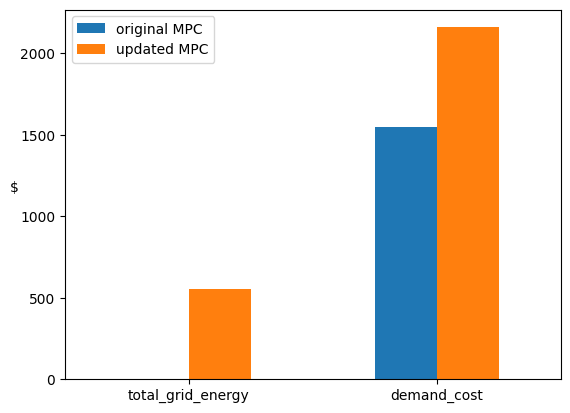

In [ ]:
# compare total energy drawn from the grid in the second half of the school day
original_total_energy = np.round(cp.sum(model.opt_vars.total_load_kw[28:]).value * model.timestep_hours, 2)
updated_total_energy = np.round(cp.sum(updated_model.opt_vars.total_load_kw).value * updated_model.timestep_hours, 2)

# compare demand costs
original_demand_cost = np.round(model.objectives['demand_cost'].value / model.demand_rate_scaling_factor, 2)
updated_demand_cost = np.round(updated_model.objectives['demand_cost'].value /
                               model.demand_rate_scaling_factor, 2)

KPI_df = pd.DataFrame(
    {"total_grid_energy": [original_total_energy, updated_total_energy],
    "demand_cost": [original_demand_cost, updated_demand_cost],
    },
    index=["original MPC", "updated MPC"],
)
fig = KPI_df.T.plot.bar()
fig.set_xticklabels(
    KPI_df.columns,
    rotation=0
)
fig.set_ylabel(
    "$", rotation=0
)

In [ ]:
plot_optimal_powers(
    models_to_visualize=[model, updated_model],
    model_names=["original_model", "updated_model"],
    datetime_range=(SIMULATION_TIMESTEPS[28], datetime(2023, 9, 5, 20, tzinfo=pt)),
    title="Energy Usage during the Second Half of the First School Day")

As can be observed from the visualization above, the updated model:
1. accounts for increased vehicle energy consumption forecast by increasing the power charged into vehicles
2. due to the increased charging needs, the updated model supplements PV power with both power from the battery and power drawn from the grid, incurring energy and demand costs where there was none for the original model
3. despite nonzero slack energy, vehicle still satisfies trip energy requirements with the help of vehicle reliability buffer

## 4.5 A Toy SAC Demonstration
We show a toy SAC implementation with the school bus charging dataset, to illustrate how an RL model can be implemented in practice.
- The school bus charging station environment `SchoolBusEnv` follows the [gymnasium](https://gymnasium.farama.org/index.html) framework, which provides boilerplate code for RL environments, and allows easy experimentation with different RL algorithms
- The SAC implementation is directly taken from [stable baseline 3](https://stable-baselines3.readthedocs.io/en/master/index.html), which provide a set of reliable RL algorithms implemented in [pytorch](https://pytorch.org/).

Note that this model is not well-tuned and the implementation is for demonstration purpose only.

<!-- For reviewerrs:
 We think the reason the SAC model is currently not learning appropriately is
 the lack of rewards for violating constraints. Time allowing, we plan to implement another version of this that has the appropriate reward formulation.
-->

In [ ]:
import gymnasium as gym
from stable_baselines3 import SAC
from copy import deepcopy
from collections import namedtuple


rng = np.random.default_rng(seed=12345)
NoiseParams = namedtuple("NoiseParams", ["loc", "scale"])
noise = NoiseParams(.9, .05)

discarded_solar_cost_per_kWh = model.discarded_solar_cost_per_kWh
slack_energy_cost_per_kWh = 5
demand_period_by_index = {
    **{x: "off-peak" for x in list(range(0, 12)) + list(range(72, 96))}, # off-peak
    **{y: "mid-peak" for y in list(range(12, 28)) + list(range(52, 72))},
    **{z: "peak" for z in list(range(28, 52))}, # peak
}  # index during one day (96 steps for 15 minute time step lengths)
demand_rate_by_period = {
    "off-peak": sorted(np.unique(AGG_DEMAND_RATES))[1],
    "mid-peak": sorted(np.unique(AGG_DEMAND_RATES))[2],
    "peak": sorted(np.unique(AGG_DEMAND_RATES))[-1],
}
rng = np.random.default_rng(seed=12345)
NoiseParams = namedtuple("NoiseParams", ["loc", "scale"])


class SchoolBusEnv(gym.Env, BaseModel):
    """
    for ease of implementation,
    assuming charging vehicles at vehicle.max_input_power_kw
    does not violate site_power_limit_kw or charger.max_power_kw
    (this holds for our dataset)

    battery cycling cost is not considered but can be easily added.
    """
    def __init__(self, noise: NoiseParams | None = None,
                 constraint_violation_penalty=3, # $ / kwh
                 electricity_cost_scaler=10,
                 charging_while_driving_cost_scaler=10,
                 **kwargs):
        gym.Env.__init__(self)
        BaseModel.__init__(self, **kwargs)
        self.constraint_violation_penalty = constraint_violation_penalty
        self.electricity_cost_scaler = electricity_cost_scaler
        self.action_space = gym.spaces.Box(
            low=np.array(
                [0] * 2 # solar_used, solar_stored
                + [0] * len(self.input_params.vehicles) + [-self.input_params.battery.max_discharge_kw]
            ),
            high=np.array(
                [self.input_params.solar_generation_forecast_kw.max()] * 2 # solar_used, solar_stored
                + [vehicle.max_input_power_kw for vehicle in self.input_params.vehicles] + [self.input_params.battery.max_charge_kw]
            ),
            shape=(2+len(self.input_params.vehicles)+1,)
        )  # each action contains the vehicle charging power for each vehicle,
        # and as the last element, battery charing power
         # (discharging is represented with the same element but negative)
        # ideally we want action_space and observation_space to be represented by dictionaries (gym.spaces.Dict)
        # but the SAC implementation we have does not support nested actions
        # using a sequence for both instead
        self.observation_space = gym.spaces.Box(
            low=np.array(
                [0] * 3 # max_demand: peak, max_demand: mid-peak, max_demand: off-peak
                + [0] # battery energy
                + [0] # total_load_kw
                + [0] # energy_cost_for_step
                + [0] # demand_cost_for_step
                + [0] * len(self.input_params.vehicles) # vehicle energy
            ),
            high=np.array(
                [self.input_params.site_power_limit_kw] * 3 # max_demand: peak, max_demand: mid-peak, max_demand: off-peak
                + [self.input_params.battery.battery_capacity_kwh] # battery energy
                + [self.input_params.site_power_limit_kw] # total_load_kw
                + [self.input_params.site_power_limit_kw * max(AGG_ENERGY_RATES) * self.timestep_hours] # energy_cost_for_step
                + [self.input_params.site_power_limit_kw * max(AGG_DEMAND_RATES)] # demand_cost_for_step
                + [vehicle.battery_capacity_kwh for vehicle in self.input_params.vehicles] # vehicle energy
            ),
            shape=(7 + len(self.input_params.vehicles), )
        )
        self.initial_state = np.array([0,  # peak
                              0,  # mid-peak
                              0,  # off-peak
                              self.input_params.battery.initial_battery_energy_kwh,
                              0,  # total_load_kw
                              0,  # energy_cost_for_step
                              0,  # demand_cost_for_step
                              *[vehicle.starting_battery_energy_kwh for vehicle in self.input_params.vehicles],
                              ])
        self.system_state = deepcopy(self.initial_state)
        self.noise = noise
        self.timestep = 0

    def enforce_battery_constraint(self, action):
        battery_energy = self.system_state[3] + (action[-1] + action[1]) * self.timestep_hours
        exceeding_battery_kwh = max(battery_energy - self.input_params.battery.battery_capacity_kwh, 0)
        if exceeding_battery_kwh:
            action[-1] = action[-1] - exceeding_battery_kwh / self.timestep_hours
            battery_energy = self.input_params.battery.battery_capacity_kwh
        over_discharging_kwh = - min(battery_energy, 0)
        if over_discharging_kwh:
            action[-1] += over_discharging_kwh / self.timestep_hours
            battery_energy = 0
        self.system_state[3] = battery_energy
        return action, (over_discharging_kwh + exceeding_battery_kwh) * self.constraint_violation_penalty

    def enforce_solar_constraint(self, action):
        total_solar = action[0] +  action[1]
        exceeded_solar = max(total_solar * self.timestep_hours - self.input_params.solar_generation_forecast_kw[self.timestep], 0)
        if exceeded_solar:
            action[1]  = action[1] - exceeded_solar / self.timestep_hours # first, subtract from stored solar
            if action[1] < 0:
                action[0] = action[0] + action[1]  # subtract what still needs to be subtracted from used solar
                action[1] = 0
                if action[0] < 0:
                    action[0] = 0
        return action, (exceeded_solar * self.constraint_violation_penalty
                        + discarded_solar_cost_per_kWh
                        * max(self.input_params.solar_generation_forecast_kw[self.timestep]
                              - action[0] - action[1],
                              0)
        )


    def enforce_vehicle_constraint(self, action):
        # print(f"original action: {action[2:-1]=}")
        # print(f"original state: {self.system_state[- len(self.input_params.vehicles):]}")
        kw_charged_while_driving = action[2:-1][
            [
                vehicle.estimated_vehicle_energy_use[self.timestep] != 0
                for vehicle in self.input_params.vehicles
            ]
        ].sum()
        action[2:-1][kw_charged_while_driving > 0] = 0
        vehicle_state_after_action = (
            self.system_state[- len(self.input_params.vehicles):]
            + action[2:-1] * self.timestep_hours
        )
        kwh_exceeding_max = np.array([max(vehicle_state_after_action[i] - vehicle.battery_capacity_kwh, 0)
                                   for i, vehicle in enumerate(self.input_params.vehicles)])
        action[2:-1] = action[2:-1] - kwh_exceeding_max / self.timestep_hours
        # print(f"{kwh_exceeding_max=}")
        # print(f"{vehicle_state_after_action=}")
        # print(f"{self.observation_space.high[-len(self.input_params.vehicles):][kwh_exceeding_max > 0]=}")
        # print(f"{self.observation_space.high[-len(self.input_params.vehicles):][kwh_exceeding_max > 0]=}")
        vehicle_state_after_action[kwh_exceeding_max > 0] = self.observation_space.high[-len(self.input_params.vehicles):][kwh_exceeding_max > 0]
        vehicle_state_after_action = vehicle_state_after_action - np.array([
            vehicle.estimated_vehicle_energy_use[self.timestep] for vehicle in self.input_params.vehicles]
        )
        missing_energy = vehicle_state_after_action[vehicle_state_after_action < 0]
        vehicle_state_after_action[vehicle_state_after_action < 0] = 0
        self.system_state[-len(self.input_params.vehicles):] = vehicle_state_after_action
        # print(f"updated action: {action[2:-1]=}")
        return action, (
                kw_charged_while_driving * self.timestep_hours * kw_charged_while_driving
                + kwh_exceeding_max.sum() * self.constraint_violation_penalty
                + missing_energy.sum() * slack_energy_cost_per_kWh
        )

    def enforce_charger_constraint(self, action):
        # not implemented due to simplifying assumption
        return action, 0

    def enforce_total_load_constraint(self, action):
        total_vehicle_charging_input = (action[2:-1]
                                        / np.array([vehicle.charging_efficiency for vehicle in self.input_params.vehicles])
        ).sum()
        total_load = total_vehicle_charging_input + action[-1] - action[0]  # adding in battery charge subtract solar use
        total_load_exceeding_max = max(total_load - self.input_params.site_power_limit_kw, 0)
        total_load_lower_than_zero = 0
        if total_load_exceeding_max:
            total_load = self.input_params.site_power_limit_kw
        elif total_load < 0:
            total_load_lower_than_zero = 0 - total_load
            total_load = 0
        self.system_state[4] = total_load
        return action, (total_load_lower_than_zero + total_load_exceeding_max) * self.constraint_violation_penalty

    def step(self, action):
        action = np.array(action)
        action, solar_constraint_cost = self.enforce_solar_constraint(action)
        action, battery_constraint_cost = self.enforce_battery_constraint(action)
        action, total_load_constraint_cost = self.enforce_total_load_constraint(action)
        action, vehicle_constraint_cost = self.enforce_vehicle_constraint(action)
        observation = deepcopy(self.system_state)


        observation[5] = observation[4] * self.timestep_hours * AGG_ENERGY_RATES[self.timestep]
        # energy_cost_for_step
        demand_cost_for_step = 0
        demand_rate_period = demand_period_by_index[self.timestep % (24 / self.timestep_hours)]
        # peak / mid-peak / off-peak
        demand_rate = demand_rate_by_period[demand_rate_period]
        if demand_rate_period == "peak":
            system_state_idx_for_max_demand = 0
        elif demand_rate_period == "mid-peak":
            system_state_idx_for_max_demand = 1
        else:
            system_state_idx_for_max_demand = 2
        demand_rate_delta = max(
            observation[4] - observation[system_state_idx_for_max_demand]
            , 0)
        observation[system_state_idx_for_max_demand] += demand_rate_delta
        observation[6] = demand_rate * demand_rate_delta # demand_cost_for_step

        if self.noise:
            observation[-len(self.input_params.vehicles):] *= rng.normal(self.noise.loc, self.noise.scale)
            observation[3] *= rng.normal(self.noise.loc, self.noise.scale)  # battery energy
        reward = - (
                (observation[6]
                + observation[5]) * self.electricity_cost_scaler
                + solar_constraint_cost + battery_constraint_cost + vehicle_constraint_cost + total_load_constraint_cost
        )
        self.timestep += 1
        self.system_state = observation
        terminated = self.timestep == len(SIMULATION_TIMESTEPS)  # end of an episode, after which self.reset is called
        observation = observation.tolist()
        return observation, reward, terminated, False, dict(action=action)



    def reset(self, seed=None, options=None):
        self.system_state = deepcopy(self.initial_state)
        observation = deepcopy(self.initial_state)
        self.timestep = 0
        return observation, dict()

    def render(self):
        ...

    def solve(self):
        ...

In [ ]:
from stable_baselines3.common.noise import NormalActionNoise
env = SchoolBusEnv(
    input_params=input_params,
    optimization_timesteps = np.array(SIMULATION_TIMESTEPS[: int(3600 * 24 / 900)]),
    electricity_cost_scaler=50,
    constraint_violation_penalty=10,
    charging_while_driving_cost_scaler=10,
)
env.reset()
sac_model = SAC("MlpPolicy", env, verbose=2, learning_starts=96,
                learning_rate=1e-6, seed=12345,)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [ ]:
obs_no_training = []
rewards_no_training = []
actions_no_training = []
obs, info = env.reset()
for _ in range(len(SIMULATION_TIMESTEPS)):
    _action, _states = sac_model.predict(obs, deterministic=True)
    obs, reward, terminated, truncated, info = env.step(_action)
    obs_no_training.append(obs)
    actions_no_training.append(info["action"])
    rewards_no_training.append(reward)
    if terminated or truncated:
        obs, info = env.reset()
obs_no_training = np.array(obs_no_training)
actions_no_training = np.array(actions_no_training)

In [ ]:
env.reset()
sac_model.learn(total_timesteps=348 * 5, log_interval=1)

----------------------------------
| rollout/           |           |
|    ep_len_mean     | 348       |
|    ep_rew_mean     | -6.42e+06 |
| time/              |           |
|    episodes        | 1         |
|    fps             | 48        |
|    time_elapsed    | 7         |
|    total_timesteps | 348       |
| train/             |           |
|    actor_loss      | 309       |
|    critic_loss     | 1.04e+09  |
|    ent_coef        | 1         |
|    ent_coef_loss   | -0.064    |
|    learning_rate   | 1e-06     |
|    n_updates       | 251       |
----------------------------------
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 348       |
|    ep_rew_mean     | -6.07e+06 |
| time/              |           |
|    episodes        | 2         |
|    fps             | 39        |
|    time_elapsed    | 17        |
|    total_timesteps | 696       |
| train/             |           |
|    actor_loss      | 259       |
|    critic_loss    

As can be seen from the loss associated with each training episode, our toy implementation of SAC is not trained till convergent. This may be due to many factors, such as the selection of learning rate and the implementation of penalty for constraint violation. We have not spent time tuning these parameters.

In [ ]:
all_obs = []
total_rewards = []
all_actions = []
obs, info = env.reset()
for _ in range(len(SIMULATION_TIMESTEPS)):
    _action, _states = sac_model.predict(obs, deterministic=True)
    obs, reward, terminated, truncated, info = env.step(_action)
    all_obs.append(obs)
    all_actions.append(info["action"])
    total_rewards.append(reward)
    if terminated or truncated:
        obs, info = env.reset()
all_obs = np.array(all_obs)
all_actions = np.array(all_actions)

In [ ]:
import plotly.express as px
fig = go.Figure()
fig.add_trace(
    go.Scatter(
        x=model.optimization_timesteps,
        y=np.array(all_obs)[:96, 4],
        name="trained for 5 episodes",
    )
)
fig.add_trace(
    go.Scatter(
        x=model.optimization_timesteps,
        y=np.array(obs_no_training)[:96, 4],
        name="without training",
    )
)
fig.update_layout(title="total load on grid from SAC Model",
                  legend_font=dict(size=12))
fig.update_xaxes(title="", tickfont = dict(size=12))
fig.update_yaxes(title="power (kW)", title_font_size=15, tickfont = dict(size=15))
color_time_of_use_periods(fig, model.optimization_timestep_indices)
fig.show()

In [ ]:
all_obs = np.array(all_obs)
# plug in the values from the observations above, and generate the plot
all_actions[
    :len(model.optimization_timesteps), 2:-1][all_actions[
    :len(model.optimization_timesteps), 2:-1] < 0] = 0
env.opt_vars.vehicle_charging_power.value = all_actions[
    :len(model.optimization_timesteps), 2:-1]
env.opt_vars.solar_stored_kw.value = np.expand_dims(all_obs[:len(model.optimization_timesteps), 1
    ], axis=1)
env.opt_vars.solar_used_kw.value = np.zeros(env.opt_vars.solar_used_kw.shape)
env.opt_vars.battery_charging_power.value = all_actions[:len(model.optimization_timesteps),
                                                    3].reshape(env.opt_vars.battery_charging_power.shape)
env.opt_vars.battery_discharging_power.value = np.zeros(shape=env.opt_vars.battery_discharging_power.shape)
env.opt_vars.total_load_kw.value = all_obs[
    :len(model.optimization_timesteps), 4].reshape(env.opt_vars.total_load_kw.shape)
total_vehicle_charging_power = (env.opt_vars.total_load_kw.value
                                             - env.opt_vars.battery_charging_power.value
                                             + env.opt_vars.solar_used_kw.value.sum(axis=1, keepdims=True)
                                             )
total_vehicle_charging_power[total_vehicle_charging_power < 0] = 0
env.opt_vars.vehicle_charging_power.value = np.hstack([total_vehicle_charging_power / len(input_params.vehicles)] * len(input_params.vehicles))
plot_optimal_powers([env],
                    datetime_range=(SIMULATION_TIMESTEPS[0],
                                    datetime(2023, 9, 5, 21, tzinfo=pt)),
                    model_names=["SAC"])

<a name="results-and-discussion"></a>
# 6. Results & Discussion

## 6.1 Summary
Using the synthetic school bus charging dataset, we demonstrated how ZEVi's MPC could trade off multiple common objectives in ZEV charging scenarios, and appropriately respond to feedback from the system through running multiple iterations of optimization with with a rolling time horizon. Compared with the eager charging baseline algorithm, ZEVi's MPC is able to substantially reduce the cost of operation for ZEV fleets, reducing the barrier of entry for fleets transitioning from ICEVs to ZEVs.

## 6.2 Limitations
We list some limitations to the MPC algorithm demonstrated :
1. We made the simplifying assumption of constant charging efficiency for each ZEV. In reality, ZEV battery charging effiency is a function of its state of charge (SOC), usually peaking at a relatively low SOC and tapering off as the battery approaches full.
2. We disregarded factors impacting BESS performance, such as self-discharge and storage capacity degradation over time. Without charging or discharging, BESS loses its stored energy over time at a small rate due to its internal chemical process. This shouldn't have a big impact on the optimization given our relatively short simulation period of 4 days, but it's worth accounting for in a charging station's actual operation.
3. An emerging lever that may help improve grid efficiency is vehicle-to-grid (V2G) technology, which allows ZEVs to inject power from their batteries to the grid, helping fulfill demands and relieving the strain on the grid. V2G can also provide additional financial incentives to ZEV owners, in cases where the energy flow from ZEV to the grid is compensated. The MPC demonstrated in this tutorial does not consider V2G, which is an opportunity to further improve the optimization.
4. The assumptions of the dataset (Section 2.2) limits the ZEVi MPC's use case to charging stations used by a fixed fleet of ZEVs, which means adjustments need to be made for the public charging use case, where there's an undetermined number of ZEVs that the charging station needs to support. [20] provides one example of using reinforcement learning to solve the public charging use case.

Additionally, one obvious limitation is our SAC implementation. We have not spent any significant amount of time implementing appropriate reward mechanism and tuning hyperparameters such as learning rates. The audience is encouraged to experiment with this demonstration and see how changing the rewards may affect the model's behavior.


## 6.3 Next Steps
We hope this tutorial has provided you with some context on the problem of ZEV charging optimization, and a helpful introduction to some applicable methodologies. It's worth noting that MPC and RL algorithms can be used in many other areas of climate solutions: in-door climate optimization [21], water heater load optimization [22], waste water management [23] [24], carbon storage planning [25], resource management strategy discovery [26], and many more.

We encourage you to leave this tutorial asking questions like: What are some additional ways that MPC and RL algorithms can be applied to mitigate climate change? Could you apply what you learned from this tutorial to your current area of work, or a problem you are interested in working on? Are there specific aspects of this tutorial that you'd like to learn more about: e.g. electricity load management, different reinforcement learning methods, etc?

Thank you.



#Appendix: Detailed Mathematical Formulation for ZEVi MPC
*Note: This is included for completeness and not required to understand the tutorial.*

In our notation, hats over a variable (e.g., $\hat{p}_{port}^{m}$) indicate it is a *decision variable* (i.e., one that the solver has control over). Over- and under-bars (e.g., $\overline{soc}_{vehicle}^{m}$ and $\underline{soc}_{vehicle}^{m}$) indicate maximum and minimum limits, respectively.


##### **Objective Function**

ZEVi's objective function that we are trying to minimize can be expressed as

\begin{equation}
    f = f_{energy} + f_{demand} + f_{bess-cycling} + f_{slack-energy} + f_{discarded-solar}, \tag{6}
\end{equation}

where each term is described below.

**Energy Cost**

The goal of the energy cost term, $f_{energy}$, is to minimize the monetary cost associated with energy consumption. For this we multiply the total energy passing through the meter at timestep $t$, $\hat{p}_{total}[t] * \Delta{t}$, by the energy-rate at that timestep, $r_{energy}[t]$, and sum the results over all timesteps $\mathcal{T} = \{1, \ldots, T\}$

\begin{equation}
    f_{energy} = \sum_{t=1}^{T} \left(\hat{p}_{total}[t] \: \frac{\Delta t}{60} \: r_{energy}[t]\right), \tag{7}
\end{equation}

where $\Delta{t}$ is the timestep length in minutes (typically 15) and the total load passing through the meter at timestep $t$ is defined as

\begin{equation}
   \hat{p}_{total}[t] = \eta_{bess, ch} \: \hat{p}_{bess, ch}[t] - \eta_{bess, dis} \: \hat{p}_{bess, dis}[t] - \hat{p}_{solar-used}[t] - \hat{p}_{solar-stored} + \sum_{m=1}^{M} \hat{p}_{port}^{m}[t], \tag{8}
\end{equation}

where $\eta_{bess, ch}$ and $\eta_{bess, dis}$ are the charging and discharging efficiencies of the BESS, respectively, $\hat{p}_{bess, ch}[t]$ and $\hat{p}_{bess, dis}[t]$ are the amount of power going into and out of the BESS at timestep $t$,respectively, $\hat{p}_{solar-used}[t]$ is the amount of solar power generated at timestep $t$ used to charge the vehicles, $\hat{p}_{solar-stored}[t]$ is the amount of solar power generated at timestep $t$ stored in the battery, and $\sum_{m=1}^{M} \hat{p}_{port}^{m}[t]$ is the amount of power drawn by all charger ports at timestep $t$.

**Maximum-Demand Cost**

The goal of the maximum-demand cost term, $f_{demand}$, is to minimize the monetary cost associated with demand rates. For this we multiply the maximum demand for the time-of-use (TOU) period $i$, $\hat{y}[i]$, by the tariff's demand rate at that TOU period, $r_{demand}[i]$ and sum the results over all TOU periods $\mathcal{I} = \{1, \ldots, I\}$


\begin{equation}
    f_{demand} = \omega_{demand} \: \sum_{i=1}^{I} \left( r_{demand}[i] \: \hat{y}[i] \right), \tag{9}
\end{equation}

where $\omega_{demand}$ is the demand weight, which allows us to increase or decrease the weight of this term in the overall objective function. We define the demand weight as the inverse of the number of days remaining in the billing period, $a$,

\begin{equation}
    \omega_{demand} = \frac{1}{a}. \tag{10}
\end{equation}

**BESS-Cycling Cost**

The goal of the BESS-cycling cost term, $f_{bess-cycling}$ is to minimize the degradation associated with cycling the battery. For this we multiply the monetary cost of each BESS charging / discharging cycle, $r_{bess}$ by the net energy flow into the BESS at timestep $t$, $(\hat{p}_{bess, ch}[t] - \hat{p}_{bess, dis}[t]) * \frac{\Delta t}{60}$, divide by the energy capacity of the BESS, $\overline{e}_{bess}$, and sum over all timesteps

\begin{equation}
    f_{bess-cycling} = r_{bess} \sum_{t=1}^{T} \frac{\left(\hat{p}_{bess, ch}[t] + \hat{p}_{bess, dis}[t]\right)}{\overline{e}_{bess}} \: \frac{\Delta t}{60}, \tag{11}
\end{equation}

where $\hat{p}_{bess, dis}[t]$ is the amount of power flowing out of the BESS at timestep $t$.

**Slack-Energy Cost**

Slack energy, $\hat{e}_{slack}^{m}$ is a "slack" term added to the vehicle energy-balance equation in order to prevent infeasible solutions. If a vehicle requires more energy during its trips than the vehicle has time to charge (e.g., a long trip is scheduled but the vehicle has a very short dwell period at the depot), then the slack energy variable for that vehicle takes on a positive value at some time steps during the trip. This prevents the vehicle not meeting its energy requirements from breaking any constraints, enabling the solver to always find a viable solution. However, it is important to note positive nonzero slack energy for a vehicle indicates that vehicle cannot meet the energy requirements for its trips with the pre-specified vehicle reliability buffer, $e_{buffer}^{m}$. The vehicle reliability buffer is an artificially imposed requirement that vehicle $m$ always have $e_{buffer}^{m}$ kWh more than its predicted energy need at each timestep, increasing its ability to cope with unforeseen events. Reducing the vehicle reliability buffer reduces the chance of nonzero slack, but increases the risk the vehicle cannot complete its trips in the case of unforeseen events. In contrast, increasing the vehicle reliability buffer decreases the risk a vehicle runs out of energy on its trips but increases the chance of positive nonzero slack.

The slack-energy cost, $f_{slack-energy}$, penalizes non-zero slack-energy values,  thereby encouraging the solver to find a solution without using slack energy whenever possible. We express this term as

\begin{equation}
    f_{slack-energy} = \omega_{slack} \sum_{m=1}^{M} \sum_{t=1}^{T} \hat{e}_{slack}^{m}[t], \tag{12}
\end{equation}

where $\hat{e}_{slack}^{m}[t]$ is the slack energy assigned to vehicle $m$ over timestep $t$ and $\omega_{slack}$ is the slack weight, which allows us to increase or decrease the weight of this objective term. We define the slack weight as the maximum between a user-specified value, $\omega_{slack}^{*}$, and the greatest cost possible over the forecast horizon

\begin{equation}
    \omega_{slack} = \max \left( \omega_{slack}^{*}, \: \frac{\overline{p}_{total} \left( \max\{r_{demand}^{i}\}_{i=1}^{I} \: + \: \max\{r_{energy}^{t}\}_{t=1}^{T} \frac{\Delta t}{60}\:T \right)}{T * M} \right), \tag{13}
\end{equation}

where $\overline{p}_{total}$ is the power limit of the utility meter.

**Discarded-Solar Cost**

The goal of the discarded-solar term, $f_{discarded-solar}$, is to encourage the solver to maximize use of on-site solar power generation and reduce reliance on the grid. We express this term as

\begin{equation}
    f_{discarded-solar} = \omega_{discarded-solar} \: \frac{\Delta{t}}{60} \: \sum_{t=1}^{T} \hat{p}_{solar-discarded}[t] \tag{14}
\end{equation}

where $\omega_{discarded-solar}$ is the monetary cost assigned to wasting 1 kWh of generated solar energy and the amount of solar power discarded is the difference between the amount generated and the sum of that used to charge the vehicles and that stored in the battery

\begin{equation}
  \hat{p}_{solar-discarded}[t] = p_{solar-generated}[t] - \hat{p}_{solar-used}[t] - \hat{p}_{solar-stored}[t]. \tag{15}
\end{equation}

##### Constraints

ZEVi's constraints can be partitioned into semantic groups: vehicle constraints, charger/port constraints, BESS constraints, maximum-demand-rate constraints, power-limit constraints, and solar constraints. We describe each set of constraints below.

**Vehicle Constraints**

First, we constrain the estimated energy in vehicle $m$ at time $t$ to equal the sum of energy in the vehicle at time $t-1$, delivered via port $m$ over the previous timestep, used by driving over the previous timestep, reserved by the vehicle's reliability buffer, and provided through slack energy during the previous timestep

\begin{equation}
    \hat{e}_{vehicle}^{m}[t]
    = \hat{e}_{vehicle}^{m}[t-1]
    + \eta_{port}^m \: \eta_{vehicle}^m \: \hat{p}_{port}^m[t-1] \: \frac{\Delta t}{60}
    - e_{driving}^m[t-1] - e_{buffer}^{m}
    + \hat{e}_{slack}^m[t-1]
    \quad \forall \: m \in \mathcal{M}, t \in \mathcal{T}, \tag{16}
\end{equation}

where $\mathcal{M} = \{1, \ldots, M\}$ is the set of vehicles and since we assume each vehicle pairs to a single port during the prediction horizon, $\mathcal{M}$ is also used to represent the set of ports, $\eta_{port}^{m}$ and $\eta_{vehicle}^{m}$ are the charging efficiencies of port and vehicle $m$, respectively, $e_{buffer}^{m}$ is the user-defined reliability buffer for vehicle $m$, and $e_{driving}^m[t-1]$ is the amount of energy vehicle $m$ used while driving over the previous timestep. We define this as

\begin{equation}
    e_{driving}^{m}[t] = \sum_{h=0}^{H_m}
    \begin{cases}
     &\frac{{d}_{trip}^{h} \frac{\overline{e}_{vehicle}^{m}}{\overline{d}_{vehicle}^{m}}} {t_{h, end}^{m} - t_{h, start}^{m}}
     &\quad \text{if } t \in \{t_{h, start}^{m}, ..., t_{h, end}^{m}\} \\
     & 0
     &\quad else
    \end{cases}, \tag{17}
\end{equation}

where $\mathcal{H} = \{0, \ldots, H_m\}$ is the set of trips associated with vehicle $m$, $d_{trip}^{h}$ is the distance of trip $h$ in miles, $\overline{e}_{vehicle}^{m}$ is the energy capacity of vehicle $m$'s battery, $\overline{d}_{vehicle}^{m}$ is vehicle $m$'s rated range in miles, and $t_{h, start}^{m}$ and $t_{h, end}^{m}$ are the times vehicle $m$ is scheduled to start and end trip $h$, respectively.

Next we constrain the energy in vehicle $m$ at time $t$ to be between vehicle $m$'s minimum and maximum allowable energy

\begin{equation}
    \underline{soc}_{vehicle}^{m} \: \overline{e}_{vehicle}^{m}
    \leq \hat{e}_{vehicle}^{m} [t]
    \leq \overline{soc}_{vehicle}^{m}\: \overline{e}_{vehicle}^{m}
    \quad \forall \:m \in \mathcal{M}, t \in \mathcal{T}, \tag{18}
\end{equation}

where $\underline{soc}_{vehicle}^{m}$ and  $\overline{soc}_{vehicle}^{m}$ are the minimium and maximum state-of-charge limits for vehicle $m$, respectively.

**Charger/Port Constraints**

First, we constrain the power output of port $m$ at timestep $t$, $\hat{p}_{port}^{m}[t]$, to be non-negative and less than vehicle $m$'s charging limit, $\overline{p}_{vehicle}^{m}$

\begin{equation}
    0
    \leq \hat{p}_{port}^{m}[t]
    \leq \frac{\overline{p}_{vehicle}^m}{\eta_{port}^m}
    \quad \forall \: m \in \mathcal{M}, t \in \mathcal{T}. \tag{19}
\end{equation}

Next, we constrain the total power output of charger $n$ at time $t$, $\sum_{V_n}\hat{p}_{port}^m[t]$, to be less than the charging limit of any ports on the charger, $\overline{p}_{port}^m$

\begin{equation}
    \sum_{V_n} \hat{p}_{port}^m[t]
    \leq \frac{\overline{p}_{port}^m}{{\eta_{port}^m}}
    \quad \forall \: m \in \mathcal{M}, n \in \mathcal{N}, t \in \mathcal{T}, \tag{20}
\end{equation}

where $V_n$ is the set of all ports on charger $n$, and $\mathcal{N} = \{1, \ldots, N\}$ is the set of chargers.

Then, we constrain the power input to all ports at timestep $t$ to be greater than or equal to the power discharged by the battery to the ports at timestep $t$ plus the amount of solar generation used by the chargers at timestep $t$, $\hat{p}_{solar-used}[t]$

\begin{equation}
    \sum_{m=1}^{M} \hat{p}_{port}^{m}[t] \geq \: \eta_{bess, dis} \: \hat{p}_{bess, dis}[t] + \hat{p}_{solar-used}[t]. \tag{21}
\end{equation}

Finally, to ensure the solver does not permit solutions that deliver power to a vehicle while it is driving, we constrain the power output of port $m$ to equal 0 kWh when vehicle $m$ is on a trip

\begin{equation}
    \hat{p}_{port}^m [t] = 0
    \quad \forall \: m \in \mathcal{M}, h \in \mathcal{H_{m}}, t \in \{t_{h,s}^{m}, \ldots, t_{h,e}^{m}\}. \tag{22}
\end{equation}

**BESS Constraints**

First we constrain the amount of energy in the BESS at timestep $t$, $\hat{e}_{bess}[t]$, to equal the sum of energy in the BESS at the start of the last timestep, received via charging from the grid over the last timestep, received via charging from on-site solar generation over the last timestep, and discharged to the charging ports over the last timestep. We formally define this constraint as

\begin{equation}
    \hat{e}_{bess}[t]
    = \hat{e}_{bess}[t-1]
    + \left( \eta_{bess, ch} \left( \hat{p}_{bess, ch}[t-1] + \hat{p}_{solar-stored}[t-1] \right) - \eta_{bess, dis} \: \hat{p}_{bess, dis}[t-1] \right) \: \frac{\Delta t}{60}
    \quad \forall \:t \in \mathcal{T}. \tag{23}
\end{equation}

Next, we constrain the amount of power going into the BESS at timestep $t$ to be non-negative and less than its charging limit, $\overline{p}_{bess, ch}$

\begin{equation}
    0 \leq \hat{p}_{bess, ch}[t]\leq \overline{p}_{bess, ch} \quad \forall \: t \in \mathcal{T}. \tag{24}
\end{equation}

Likewise, we constrain the amount of power going out of the BESS at timestep $t$ to be non-negative and less than its discharging limit, $\overline{p}_{bess, dis}$

\begin{equation}
    0 \leq \hat{p}_{bess, dis}[t]\leq \overline{p}_{bess, dis} \quad \forall \: t \in \mathcal{T}. \tag{25}
\end{equation}

Then, we ensure the BESS's energy estimate at timestep $t$ is between its minimum and maximum allowable energy

\begin{equation}
    \underline{soc}_{bess}\:\overline{e}_{bess}
    \leq \hat{e}_{bess}[t]
    \leq \overline{soc}_{bess}\:\overline{e}_{bess} \quad \forall \: t \in \mathcal{T}, \tag{26}
\end{equation}

where $\underline{soc}_{bess}$ and $\overline{soc}_{bess}$ are the minimum and maximum state-of-charge limits for the BESS.

Lastly, we constrain the BESS's energy at timestep $T$ to equal a target value $soc_{bess, target}$, typically set to 0.5, in order to maintain the health of the BESS

\begin{equation}
    \hat{e}_{bess}[T] = \overline{e}_{bess} * soc_{bess, target}. \tag{27}
\end{equation}

**Maximum-Demand Constraints**

We define the maximum demand for TOU period $i$ as

\begin{equation}
    \hat{y}^i  = \max \left(\hat{p}_{total}[t], y_{-1}^i \right),
    \quad \forall \:i \in \mathcal{I}, t \in \tau^{i} \tag{28}
\end{equation}

where $y_{-1}^i$ is the previous maximum demand for $i$, and $\tau^i$ is the set of timesteps in $i$.

The above definition equates to the following two constraints: the total power drawn from the grid (i.e., the demand) at timestep $t$ in TOU period $i$, $\hat{p}_{total}[t]$, must be less than or equal to period $i$'s maximum demand, $\hat{y}^i$, and said maximum demand must be greater than or equal to its previous value

\begin{equation}
    \hat{p}_{total}[t] \leq \hat{y}^i
    \quad \forall \:i \in \mathcal{I}, t \in \tau^{i}, \tag{29}
\end{equation}


\begin{equation}
    \hat{y}^i \geq y_{-1}^i
    \quad \forall \: i \in \mathcal{I}. \tag{30}
\end{equation}

**Site Power Limit Constraint**

We constrain the total load passing through the site meter at timestep $t$ to be less than the meter's power limit

\begin{equation}
    \hat{p}_{total}[t] \leq \overline{p}_{total}
    \quad \forall \: t \in \mathcal{T}. \tag{31}
\end{equation}

**Solar Constraints**

We constrain the amount of solar power used to charge the vehicles and to store in the battery at each timestep to be less than or equal to the amount of solar power generated

\begin{equation}
     p_{solar-used}[t] + p_{solar-stored}[t] \leq p_{solar-generated}[t]. \tag{32}
\end{equation}

<a name="references"></a>
# References
[1] EPA (2023). Inventory of U.S. Greenhouse Gas Emissions and Sinks: 1990-2021. U.S. Environmental Protection Agency, EPA 430-R-23-002.

[2] Buberger, Johannes, Anton Kersten, Manuel Kuder, Richard Eckerle, Thomas Weyh, and Torbjörn Thiringer. "Total CO2-equivalent life-cycle emissions from commercially available passenger cars." Renewable and Sustainable Energy Reviews 159 (2022): 112158.

[3] O’Connell, Adrian, Nikita Pavlenko, Georg Bieker, and Stephanie Searle. "A comparison of the life-cycle greenhouse gas emissions of European heavy-duty vehicles and fuels." (2023).

[4] Ivanova, Gulnaz, and António Carrizo Moreira. "Antecedents of Electric Vehicle Purchase Intention from the Consumer’s Perspective: A Systematic Literature Review." Sustainability 15, no. 4 (2023): 2878.

[5] Ellerbeck, Stefan. “Electric Vehicle Sales Leapt 55% in 2022 - Here’s Where That Growth Was Strongest.” World Economic Forum. Accessed September 24, 2023. https://www.weforum.org/agenda/2023/05/electric-vehicles-ev-sales-growth-2022/.

[6] Bernardelli, A., et al. "Real-time model predictive control of a wastewater treatment plant based on machine learning." Water Science and Technology 81.11 (2020): 2391-2400.

[7] Wolf, Theodore. "Climate Change Policy Exploration using Reinforcement Learning." arXiv preprint arXiv:2211.17013 (2022).

[8] Europacable. “An Introduction to Medium and Low Voltage Cables in Distribution Networks as support of Smart Grids” June 16, 2014. https://europacable.eu/wp-content/uploads/2021/01/Introduction-to-Distribution-Networks-2014-06-16.pdf.

[9] Galus, Matthias D., Marina González Vayá, Thilo Krause, and Göran Andersson. "The role of electric vehicles in smart grids." Advances in Energy Systems: The Large‐scale Renewable Energy Integration Challenge (2019): 245-264.

[10] Lee, Zachary J., George Lee, Ted Lee, Cheng Jin, Rand Lee, Zhi Low, Daniel Chang, Christine Ortega, and Steven H. Low. "Adaptive charging networks: A framework for smart electric vehicle charging." IEEE Transactions on Smart Grid 12, no. 5 (2021): 4339-4350.

[11] Holkar, K. S. and Waghmare, L. M., "An overview of model predictive control", International Journal of Control and Automation, Volume 3, Number 4, 2010.

[12] Qin, S. J. and Badgwell, T. A.,"A survey of industrial model predictive control technology", Control Engineering Practice, Volume 11, Issue 7, 2003, Pages 733-764, ISSN 0967-0661, https://doi.org/10.1016/S0967-0661(02)00186-7.

[13] Boyd, S. and Vandenberghe, L., "Convex Optimization", Cambridge University Press, 2004, https://web.stanford.edu/~boyd/cvxbook/bv_cvxbook.pdf

[14] Gellings, Clark W. "Evolving practice of demand-side management." Journal of Modern Power Systems and Clean Energy 5, no. 1 (2017): 1-9.

[15] Strbac, Goran. "Demand side management: Benefits and challenges." Energy policy 36, no. 12 (2008): 4419-4426.

[16] Sutton, Richard S., and Andrew G. Barto. Reinforcement learning: An introduction. MIT press, 2018.

[17] Mnih, Volodymyr, Koray Kavukcuoglu, David Silver, Andrei A. Rusu, Joel Veness, Marc G. Bellemare, Alex Graves et al. "Human-level control through deep reinforcement learning." nature 518, no. 7540 (2015): 529-533.

[18] Lillicrap, Timothy P., Jonathan J. Hunt, Alexander Pritzel, Nicolas Heess, Tom Erez, Yuval Tassa, David Silver, and Daan Wierstra. "Continuous control with deep reinforcement learning." arXiv preprint arXiv:1509.02971 (2015).

[19] Haarnoja, Tuomas, Aurick Zhou, Pieter Abbeel, and Sergey Levine. "Soft actor-critic: Off-policy maximum entropy deep reinforcement learning with a stochastic actor." In International conference on machine learning, pp. 1861-1870. PMLR, 2018.

[20] Cao, Yongsheng, Hao Wang, Demin Li, and Guanglin Zhang. "Smart online charging algorithm for electric vehicles via customized actor–critic learning." IEEE Internet of Things Journal 9, no. 1 (2021): 684-694.

[21] Yang, Shiyu, Man Pun Wan, Wanyu Chen, Bing Feng Ng, and Deqing Zhai. "An adaptive robust model predictive control for indoor climate optimization and uncertainties handling in buildings." Building and Environment 163 (2019): 106326.

[22] Mande, Caton, Aref Aboud, Rachael Collins, and Matthew J. Ellis. "Timing is everything: Optimizing load flexibility of heat pump water heaters for cost, comfort, and carbon emissions." (2022).

[23] Stentoft, Peter Alexander, Thomas Munk-Nielsen, Jan Kloppenborg Møller, Henrik Madsen, Luca Vezzaro, Peter Steen Mikkelsen, and Anna Katrine Vangsgaard. "Green MPC—An approach towards predictive control for minimimal environmental impact of activated sludge processes." Proceedings of Watermatex 2019 (2019): 1-4.

[24] Chen, K., Wang, H., Valverde-Pérez, B., Zhai, S., Vezzaro, L., & Wang, A. (2021). Optimal control towards sustainable wastewater treatment plants based on multi-agent reinforcement learning. Chemosphere, 279, 130498.

[25] Sun, Alexander Y. "Optimal carbon storage reservoir management through deep reinforcement learning." Applied Energy 278 (2020): 115660.

[26] Strnad, Felix M., Wolfram Barfuss, Jonathan F. Donges, and Jobst Heitzig. "Deep reinforcement learning in World-Earth system models to discover sustainable management strategies." Chaos: An Interdisciplinary Journal of Nonlinear Science 29, no. 12 (2019).

[27] Lin, Yuan, John McPhee, and Nasser L. Azad. "Comparison of deep reinforcement learning and model predictive control for adaptive cruise control." IEEE Transactions on Intelligent Vehicles 6, no. 2 (2020): 221-231.

[28] Kolev, Kalin. "Convexity in image-based 3D surface reconstruction." PhD diss., Technische Universität München, 2012.

